In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 92)
(1079604, 3)
validation
(190293, 92)
(190293, 3)
test
(137379, 92)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:05 - loss: 1.3374 - STD: 0.1796 - MAE: 0.4436

  8/108 [=>............................] - ETA: 0s - loss: 1.1596 - STD: 0.0929 - MAE: 0.4443  

 15/108 [===>..........................] - ETA: 0s - loss: 1.1381 - STD: 0.0742 - MAE: 0.4443

 22/108 [=====>........................] - ETA: 0s - loss: 1.1270 - STD: 0.0628 - MAE: 0.4442

 29/108 [=======>......................] - ETA: 0s - loss: 1.1194 - STD: 0.0542 - MAE: 0.4439

 36/108 [=========>....................] - ETA: 0s - loss: 1.1127 - STD: 0.0476 - MAE: 0.4433

 43/108 [==========>...................] - ETA: 0s - loss: 1.1037 - STD: 0.0459 - MAE: 0.4417

 50/108 [============>.................] - ETA: 0s - loss: 1.0899 - STD: 0.0524 - MAE: 0.4378

 53/108 [=============>................] - ETA: 1s - loss: 1.0833 - STD: 0.0575 - MAE: 0.4354

 59/108 [===============>..............] - ETA: 0s - loss: 1.0704 - STD: 0.0693 - MAE: 0.4300

 65/108 [=================>............] - ETA: 0s - loss: 1.0574 - STD: 0.0789 - MAE: 0.4251

 72/108 [===================>..........] - ETA: 0s - loss: 1.0437 - STD: 0.0877 - MAE: 0.4203

 79/108 [====================>.........] - ETA: 0s - loss: 1.0313 - STD: 0.0964 - MAE: 0.4156

 86/108 [======================>.......] - ETA: 0s - loss: 1.0201 - STD: 0.1042 - MAE: 0.4112

 92/108 [========================>.....] - ETA: 0s - loss: 1.0111 - STD: 0.1103 - MAE: 0.4077

 99/108 [==========================>...] - ETA: 0s - loss: 1.0014 - STD: 0.1171 - MAE: 0.4038

106/108 [============================>.] - ETA: 0s - loss: 0.9929 - STD: 0.1233 - MAE: 0.4003

108/108 [==============================] - 3s 20ms/step - loss: 0.9907 - STD: 0.1249 - MAE: 0.3994 - val_loss: 0.8758 - val_STD: 0.2260 - val_MAE: 0.3440


Epoch 2/10000


  1/108 [..............................] - ETA: 2s - loss: 0.8619 - STD: 0.2113 - MAE: 0.3481

  8/108 [=>............................] - ETA: 0s - loss: 0.8631 - STD: 0.2165 - MAE: 0.3461

 15/108 [===>..........................] - ETA: 0s - loss: 0.8613 - STD: 0.2176 - MAE: 0.3452

 22/108 [=====>........................] - ETA: 0s - loss: 0.8585 - STD: 0.2192 - MAE: 0.3440

 29/108 [=======>......................] - ETA: 0s - loss: 0.8562 - STD: 0.2211 - MAE: 0.3427

 36/108 [=========>....................] - ETA: 0s - loss: 0.8551 - STD: 0.2222 - MAE: 0.3420

 43/108 [==========>...................] - ETA: 0s - loss: 0.8532 - STD: 0.2234 - MAE: 0.3411

 50/108 [============>.................] - ETA: 0s - loss: 0.8513 - STD: 0.2245 - MAE: 0.3402

 57/108 [==============>...............] - ETA: 0s - loss: 0.8496 - STD: 0.2256 - MAE: 0.3393

 64/108 [================>.............] - ETA: 0s - loss: 0.8478 - STD: 0.2266 - MAE: 0.3384

 71/108 [==================>...........] - ETA: 0s - loss: 0.8457 - STD: 0.2278 - MAE: 0.3374

 78/108 [====================>.........] - ETA: 0s - loss: 0.8437 - STD: 0.2290 - MAE: 0.3364

 85/108 [======================>.......] - ETA: 0s - loss: 0.8422 - STD: 0.2301 - MAE: 0.3356

 92/108 [========================>.....] - ETA: 0s - loss: 0.8406 - STD: 0.2311 - MAE: 0.3347

 99/108 [==========================>...] - ETA: 0s - loss: 0.8389 - STD: 0.2321 - MAE: 0.3339

106/108 [============================>.] - ETA: 0s - loss: 0.8373 - STD: 0.2331 - MAE: 0.3331

108/108 [==============================] - 1s 9ms/step - loss: 0.8369 - STD: 0.2333 - MAE: 0.3329 - val_loss: 0.8089 - val_STD: 0.2555 - val_MAE: 0.3129


Epoch 3/10000


  1/108 [..............................] - ETA: 2s - loss: 0.8064 - STD: 0.2444 - MAE: 0.3212

  8/108 [=>............................] - ETA: 0s - loss: 0.8081 - STD: 0.2480 - MAE: 0.3196

 15/108 [===>..........................] - ETA: 0s - loss: 0.8083 - STD: 0.2474 - MAE: 0.3201

 22/108 [=====>........................] - ETA: 0s - loss: 0.8069 - STD: 0.2488 - MAE: 0.3192

 28/108 [======>.......................] - ETA: 0s - loss: 0.8063 - STD: 0.2489 - MAE: 0.3190

 34/108 [========>.....................] - ETA: 0s - loss: 0.8065 - STD: 0.2495 - MAE: 0.3188

 40/108 [==========>...................] - ETA: 0s - loss: 0.8059 - STD: 0.2496 - MAE: 0.3186

 47/108 [============>.................] - ETA: 0s - loss: 0.8059 - STD: 0.2500 - MAE: 0.3185

 53/108 [=============>................] - ETA: 0s - loss: 0.8049 - STD: 0.2505 - MAE: 0.3180

 60/108 [===============>..............] - ETA: 0s - loss: 0.8036 - STD: 0.2508 - MAE: 0.3176

 66/108 [=================>............] - ETA: 0s - loss: 0.8025 - STD: 0.2513 - MAE: 0.3172

 72/108 [===================>..........] - ETA: 0s - loss: 0.8018 - STD: 0.2519 - MAE: 0.3167

 78/108 [====================>.........] - ETA: 0s - loss: 0.8014 - STD: 0.2521 - MAE: 0.3166

 84/108 [======================>.......] - ETA: 0s - loss: 0.8006 - STD: 0.2525 - MAE: 0.3162

 90/108 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2526 - MAE: 0.3160

 96/108 [=========================>....] - ETA: 0s - loss: 0.7990 - STD: 0.2531 - MAE: 0.3156

102/108 [===========================>..] - ETA: 0s - loss: 0.7983 - STD: 0.2533 - MAE: 0.3154

108/108 [==============================] - 1s 10ms/step - loss: 0.7976 - STD: 0.2537 - MAE: 0.3150 - val_loss: 0.7788 - val_STD: 0.2639 - val_MAE: 0.3039


Epoch 4/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7833 - STD: 0.2537 - MAE: 0.3123

  8/108 [=>............................] - ETA: 0s - loss: 0.7804 - STD: 0.2591 - MAE: 0.3089

 15/108 [===>..........................] - ETA: 0s - loss: 0.7810 - STD: 0.2601 - MAE: 0.3085

 22/108 [=====>........................] - ETA: 0s - loss: 0.7815 - STD: 0.2599 - MAE: 0.3088

 28/108 [======>.......................] - ETA: 0s - loss: 0.7811 - STD: 0.2594 - MAE: 0.3090

 34/108 [========>.....................] - ETA: 0s - loss: 0.7800 - STD: 0.2600 - MAE: 0.3085

 41/108 [==========>...................] - ETA: 0s - loss: 0.7786 - STD: 0.2606 - MAE: 0.3078

 48/108 [============>.................] - ETA: 0s - loss: 0.7779 - STD: 0.2611 - MAE: 0.3075

 55/108 [==============>...............] - ETA: 0s - loss: 0.7774 - STD: 0.2611 - MAE: 0.3074

 62/108 [================>.............] - ETA: 0s - loss: 0.7770 - STD: 0.2613 - MAE: 0.3072

 68/108 [=================>............] - ETA: 0s - loss: 0.7763 - STD: 0.2615 - MAE: 0.3069

 75/108 [===================>..........] - ETA: 0s - loss: 0.7761 - STD: 0.2619 - MAE: 0.3067

 81/108 [=====================>........] - ETA: 0s - loss: 0.7755 - STD: 0.2622 - MAE: 0.3064

 88/108 [=======================>......] - ETA: 0s - loss: 0.7749 - STD: 0.2623 - MAE: 0.3062

 95/108 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2626 - MAE: 0.3059

102/108 [===========================>..] - ETA: 0s - loss: 0.7739 - STD: 0.2627 - MAE: 0.3058

108/108 [==============================] - 1s 9ms/step - loss: 0.7732 - STD: 0.2630 - MAE: 0.3055 - val_loss: 0.7611 - val_STD: 0.2801 - val_MAE: 0.2925


Epoch 5/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7622 - STD: 0.2680 - MAE: 0.3009

  7/108 [>.............................] - ETA: 0s - loss: 0.7603 - STD: 0.2686 - MAE: 0.2999

 14/108 [==>...........................] - ETA: 0s - loss: 0.7639 - STD: 0.2687 - MAE: 0.3006

 20/108 [====>.........................] - ETA: 0s - loss: 0.7669 - STD: 0.2688 - MAE: 0.3010

 27/108 [======>.......................] - ETA: 0s - loss: 0.7667 - STD: 0.2685 - MAE: 0.3012

 34/108 [========>.....................] - ETA: 0s - loss: 0.7661 - STD: 0.2680 - MAE: 0.3013

 40/108 [==========>...................] - ETA: 0s - loss: 0.7660 - STD: 0.2677 - MAE: 0.3015

 47/108 [============>.................] - ETA: 0s - loss: 0.7651 - STD: 0.2676 - MAE: 0.3013

 53/108 [=============>................] - ETA: 0s - loss: 0.7636 - STD: 0.2678 - MAE: 0.3009

 60/108 [===============>..............] - ETA: 0s - loss: 0.7631 - STD: 0.2680 - MAE: 0.3007

 66/108 [=================>............] - ETA: 0s - loss: 0.7629 - STD: 0.2683 - MAE: 0.3005

 73/108 [===================>..........] - ETA: 0s - loss: 0.7623 - STD: 0.2684 - MAE: 0.3003

 80/108 [=====================>........] - ETA: 0s - loss: 0.7619 - STD: 0.2685 - MAE: 0.3002

 87/108 [=======================>......] - ETA: 0s - loss: 0.7610 - STD: 0.2687 - MAE: 0.2999

 94/108 [=========================>....] - ETA: 0s - loss: 0.7607 - STD: 0.2688 - MAE: 0.2997

100/108 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2690 - MAE: 0.2995

107/108 [============================>.] - ETA: 0s - loss: 0.7600 - STD: 0.2692 - MAE: 0.2994

108/108 [==============================] - 1s 9ms/step - loss: 0.7599 - STD: 0.2692 - MAE: 0.2994 - val_loss: 0.7577 - val_STD: 0.2807 - val_MAE: 0.2909


Epoch 6/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7694 - STD: 0.2694 - MAE: 0.3012

  8/108 [=>............................] - ETA: 0s - loss: 0.7565 - STD: 0.2709 - MAE: 0.2977

 15/108 [===>..........................] - ETA: 0s - loss: 0.7566 - STD: 0.2710 - MAE: 0.2977

 22/108 [=====>........................] - ETA: 0s - loss: 0.7566 - STD: 0.2716 - MAE: 0.2974

 29/108 [=======>......................] - ETA: 0s - loss: 0.7557 - STD: 0.2715 - MAE: 0.2973

 36/108 [=========>....................] - ETA: 0s - loss: 0.7545 - STD: 0.2715 - MAE: 0.2970

 43/108 [==========>...................] - ETA: 0s - loss: 0.7534 - STD: 0.2715 - MAE: 0.2968

 50/108 [============>.................] - ETA: 0s - loss: 0.7522 - STD: 0.2718 - MAE: 0.2964

 57/108 [==============>...............] - ETA: 0s - loss: 0.7516 - STD: 0.2720 - MAE: 0.2961

 64/108 [================>.............] - ETA: 0s - loss: 0.7512 - STD: 0.2723 - MAE: 0.2959

 71/108 [==================>...........] - ETA: 0s - loss: 0.7510 - STD: 0.2723 - MAE: 0.2959

 77/108 [====================>.........] - ETA: 0s - loss: 0.7508 - STD: 0.2723 - MAE: 0.2958

 84/108 [======================>.......] - ETA: 0s - loss: 0.7504 - STD: 0.2723 - MAE: 0.2957

 91/108 [========================>.....] - ETA: 0s - loss: 0.7501 - STD: 0.2726 - MAE: 0.2955

 97/108 [=========================>....] - ETA: 0s - loss: 0.7500 - STD: 0.2727 - MAE: 0.2954

104/108 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2729 - MAE: 0.2952

108/108 [==============================] - 1s 10ms/step - loss: 0.7493 - STD: 0.2730 - MAE: 0.2951 - val_loss: 0.7414 - val_STD: 0.2936 - val_MAE: 0.2792


Epoch 7/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7389 - STD: 0.2776 - MAE: 0.2907

  8/108 [=>............................] - ETA: 0s - loss: 0.7401 - STD: 0.2759 - MAE: 0.2916

 15/108 [===>..........................] - ETA: 0s - loss: 0.7400 - STD: 0.2767 - MAE: 0.2912

 22/108 [=====>........................] - ETA: 0s - loss: 0.7421 - STD: 0.2760 - MAE: 0.2920

 29/108 [=======>......................] - ETA: 0s - loss: 0.7422 - STD: 0.2758 - MAE: 0.2921

 36/108 [=========>....................] - ETA: 0s - loss: 0.7429 - STD: 0.2759 - MAE: 0.2922

 43/108 [==========>...................] - ETA: 0s - loss: 0.7448 - STD: 0.2758 - MAE: 0.2926

 49/108 [============>.................] - ETA: 0s - loss: 0.7446 - STD: 0.2756 - MAE: 0.2927

 55/108 [==============>...............] - ETA: 0s - loss: 0.7445 - STD: 0.2753 - MAE: 0.2928

 62/108 [================>.............] - ETA: 0s - loss: 0.7441 - STD: 0.2754 - MAE: 0.2927

 68/108 [=================>............] - ETA: 0s - loss: 0.7440 - STD: 0.2756 - MAE: 0.2926

 74/108 [===================>..........] - ETA: 0s - loss: 0.7441 - STD: 0.2757 - MAE: 0.2926

 81/108 [=====================>........] - ETA: 0s - loss: 0.7435 - STD: 0.2756 - MAE: 0.2925

 88/108 [=======================>......] - ETA: 0s - loss: 0.7432 - STD: 0.2758 - MAE: 0.2923

 95/108 [=========================>....] - ETA: 0s - loss: 0.7429 - STD: 0.2760 - MAE: 0.2921

101/108 [===========================>..] - ETA: 0s - loss: 0.7426 - STD: 0.2761 - MAE: 0.2920

107/108 [============================>.] - ETA: 0s - loss: 0.7423 - STD: 0.2761 - MAE: 0.2920

108/108 [==============================] - 1s 9ms/step - loss: 0.7423 - STD: 0.2761 - MAE: 0.2920 - val_loss: 0.7391 - val_STD: 0.2945 - val_MAE: 0.2788


Epoch 8/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7275 - STD: 0.2820 - MAE: 0.2854

  8/108 [=>............................] - ETA: 0s - loss: 0.7366 - STD: 0.2767 - MAE: 0.2906

 14/108 [==>...........................] - ETA: 0s - loss: 0.7366 - STD: 0.2773 - MAE: 0.2902

 21/108 [====>.........................] - ETA: 0s - loss: 0.7367 - STD: 0.2776 - MAE: 0.2901

 28/108 [======>.......................] - ETA: 0s - loss: 0.7377 - STD: 0.2775 - MAE: 0.2903

 34/108 [========>.....................] - ETA: 0s - loss: 0.7378 - STD: 0.2774 - MAE: 0.2904

 41/108 [==========>...................] - ETA: 0s - loss: 0.7381 - STD: 0.2776 - MAE: 0.2904

 47/108 [============>.................] - ETA: 0s - loss: 0.7372 - STD: 0.2776 - MAE: 0.2901

 53/108 [=============>................] - ETA: 0s - loss: 0.7365 - STD: 0.2779 - MAE: 0.2898

 59/108 [===============>..............] - ETA: 0s - loss: 0.7362 - STD: 0.2779 - MAE: 0.2898

 66/108 [=================>............] - ETA: 0s - loss: 0.7359 - STD: 0.2782 - MAE: 0.2895

 73/108 [===================>..........] - ETA: 0s - loss: 0.7357 - STD: 0.2781 - MAE: 0.2895

 80/108 [=====================>........] - ETA: 0s - loss: 0.7358 - STD: 0.2782 - MAE: 0.2895

 87/108 [=======================>......] - ETA: 0s - loss: 0.7359 - STD: 0.2782 - MAE: 0.2895

 93/108 [========================>.....] - ETA: 0s - loss: 0.7359 - STD: 0.2782 - MAE: 0.2895

100/108 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2783 - MAE: 0.2895

107/108 [============================>.] - ETA: 0s - loss: 0.7360 - STD: 0.2784 - MAE: 0.2894

108/108 [==============================] - 1s 9ms/step - loss: 0.7362 - STD: 0.2784 - MAE: 0.2894 - val_loss: 0.7409 - val_STD: 0.2969 - val_MAE: 0.2764


Epoch 9/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7444 - STD: 0.2814 - MAE: 0.2894

  8/108 [=>............................] - ETA: 0s - loss: 0.7401 - STD: 0.2777 - MAE: 0.2906

 15/108 [===>..........................] - ETA: 0s - loss: 0.7375 - STD: 0.2771 - MAE: 0.2903

 22/108 [=====>........................] - ETA: 0s - loss: 0.7356 - STD: 0.2778 - MAE: 0.2896

 29/108 [=======>......................] - ETA: 0s - loss: 0.7353 - STD: 0.2783 - MAE: 0.2893

 35/108 [========>.....................] - ETA: 0s - loss: 0.7346 - STD: 0.2786 - MAE: 0.2890

 41/108 [==========>...................] - ETA: 0s - loss: 0.7341 - STD: 0.2787 - MAE: 0.2888

 48/108 [============>.................] - ETA: 0s - loss: 0.7347 - STD: 0.2784 - MAE: 0.2891

 54/108 [==============>...............] - ETA: 0s - loss: 0.7345 - STD: 0.2784 - MAE: 0.2891

 60/108 [===============>..............] - ETA: 0s - loss: 0.7347 - STD: 0.2786 - MAE: 0.2890

 66/108 [=================>............] - ETA: 0s - loss: 0.7343 - STD: 0.2788 - MAE: 0.2888

 72/108 [===================>..........] - ETA: 0s - loss: 0.7346 - STD: 0.2790 - MAE: 0.2888

 79/108 [====================>.........] - ETA: 0s - loss: 0.7347 - STD: 0.2790 - MAE: 0.2888

 86/108 [======================>.......] - ETA: 0s - loss: 0.7342 - STD: 0.2790 - MAE: 0.2887

 93/108 [========================>.....] - ETA: 0s - loss: 0.7343 - STD: 0.2790 - MAE: 0.2887

 99/108 [==========================>...] - ETA: 0s - loss: 0.7339 - STD: 0.2791 - MAE: 0.2886

105/108 [============================>.] - ETA: 0s - loss: 0.7339 - STD: 0.2791 - MAE: 0.2886

108/108 [==============================] - 1s 9ms/step - loss: 0.7338 - STD: 0.2791 - MAE: 0.2886 - val_loss: 0.7321 - val_STD: 0.2871 - val_MAE: 0.2811


Epoch 10/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7383 - STD: 0.2753 - MAE: 0.2918

  8/108 [=>............................] - ETA: 0s - loss: 0.7311 - STD: 0.2784 - MAE: 0.2884

 15/108 [===>..........................] - ETA: 0s - loss: 0.7314 - STD: 0.2796 - MAE: 0.2877

 22/108 [=====>........................] - ETA: 0s - loss: 0.7310 - STD: 0.2804 - MAE: 0.2871

 28/108 [======>.......................] - ETA: 0s - loss: 0.7320 - STD: 0.2806 - MAE: 0.2872

 35/108 [========>.....................] - ETA: 0s - loss: 0.7339 - STD: 0.2802 - MAE: 0.2879

 42/108 [==========>...................] - ETA: 0s - loss: 0.7343 - STD: 0.2797 - MAE: 0.2883

 49/108 [============>.................] - ETA: 0s - loss: 0.7343 - STD: 0.2791 - MAE: 0.2886

 56/108 [==============>...............] - ETA: 0s - loss: 0.7335 - STD: 0.2795 - MAE: 0.2883

 63/108 [================>.............] - ETA: 0s - loss: 0.7328 - STD: 0.2798 - MAE: 0.2880

 70/108 [==================>...........] - ETA: 0s - loss: 0.7322 - STD: 0.2800 - MAE: 0.2878

 77/108 [====================>.........] - ETA: 0s - loss: 0.7318 - STD: 0.2800 - MAE: 0.2877

 84/108 [======================>.......] - ETA: 0s - loss: 0.7313 - STD: 0.2801 - MAE: 0.2875

 90/108 [========================>.....] - ETA: 0s - loss: 0.7309 - STD: 0.2802 - MAE: 0.2874

 97/108 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2803 - MAE: 0.2873

104/108 [===========================>..] - ETA: 0s - loss: 0.7308 - STD: 0.2803 - MAE: 0.2873

108/108 [==============================] - 1s 9ms/step - loss: 0.7306 - STD: 0.2804 - MAE: 0.2872 - val_loss: 0.7357 - val_STD: 0.2978 - val_MAE: 0.2763


Epoch 11/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7412 - STD: 0.2850 - MAE: 0.2865

  7/108 [>.............................] - ETA: 0s - loss: 0.7357 - STD: 0.2806 - MAE: 0.2882

 14/108 [==>...........................] - ETA: 0s - loss: 0.7336 - STD: 0.2805 - MAE: 0.2878

 20/108 [====>.........................] - ETA: 0s - loss: 0.7312 - STD: 0.2802 - MAE: 0.2875

 27/108 [======>.......................] - ETA: 0s - loss: 0.7311 - STD: 0.2806 - MAE: 0.2873

 34/108 [========>.....................] - ETA: 0s - loss: 0.7305 - STD: 0.2808 - MAE: 0.2870

 41/108 [==========>...................] - ETA: 0s - loss: 0.7292 - STD: 0.2809 - MAE: 0.2867

 47/108 [============>.................] - ETA: 0s - loss: 0.7289 - STD: 0.2812 - MAE: 0.2864

 54/108 [==============>...............] - ETA: 0s - loss: 0.7283 - STD: 0.2812 - MAE: 0.2863

 61/108 [===============>..............] - ETA: 0s - loss: 0.7281 - STD: 0.2813 - MAE: 0.2862

 68/108 [=================>............] - ETA: 0s - loss: 0.7289 - STD: 0.2814 - MAE: 0.2863

 75/108 [===================>..........] - ETA: 0s - loss: 0.7287 - STD: 0.2812 - MAE: 0.2864

 82/108 [=====================>........] - ETA: 0s - loss: 0.7287 - STD: 0.2812 - MAE: 0.2864

 88/108 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2813 - MAE: 0.2864

 94/108 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2812 - MAE: 0.2865

101/108 [===========================>..] - ETA: 0s - loss: 0.7285 - STD: 0.2812 - MAE: 0.2863

108/108 [==============================] - ETA: 0s - loss: 0.7280 - STD: 0.2813 - MAE: 0.2862

108/108 [==============================] - 1s 9ms/step - loss: 0.7280 - STD: 0.2813 - MAE: 0.2862 - val_loss: 0.7259 - val_STD: 0.2947 - val_MAE: 0.2755


Epoch 12/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7149 - STD: 0.2835 - MAE: 0.2826

  8/108 [=>............................] - ETA: 0s - loss: 0.7287 - STD: 0.2826 - MAE: 0.2857

 15/108 [===>..........................] - ETA: 0s - loss: 0.7273 - STD: 0.2821 - MAE: 0.2857

 21/108 [====>.........................] - ETA: 0s - loss: 0.7263 - STD: 0.2816 - MAE: 0.2857

 28/108 [======>.......................] - ETA: 0s - loss: 0.7260 - STD: 0.2818 - MAE: 0.2856

 34/108 [========>.....................] - ETA: 0s - loss: 0.7254 - STD: 0.2819 - MAE: 0.2854

 41/108 [==========>...................] - ETA: 0s - loss: 0.7250 - STD: 0.2822 - MAE: 0.2851

 48/108 [============>.................] - ETA: 0s - loss: 0.7247 - STD: 0.2824 - MAE: 0.2849

 55/108 [==============>...............] - ETA: 0s - loss: 0.7247 - STD: 0.2825 - MAE: 0.2849

 61/108 [===============>..............] - ETA: 0s - loss: 0.7253 - STD: 0.2822 - MAE: 0.2852

 67/108 [=================>............] - ETA: 0s - loss: 0.7250 - STD: 0.2822 - MAE: 0.2851

 74/108 [===================>..........] - ETA: 0s - loss: 0.7249 - STD: 0.2823 - MAE: 0.2850

 80/108 [=====================>........] - ETA: 0s - loss: 0.7247 - STD: 0.2823 - MAE: 0.2850

 86/108 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2823 - MAE: 0.2849

 92/108 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2823 - MAE: 0.2850

 99/108 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2824 - MAE: 0.2849

106/108 [============================>.] - ETA: 0s - loss: 0.7246 - STD: 0.2824 - MAE: 0.2849

108/108 [==============================] - 1s 9ms/step - loss: 0.7245 - STD: 0.2824 - MAE: 0.2849 - val_loss: 0.7254 - val_STD: 0.2953 - val_MAE: 0.2758


Epoch 13/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7318 - STD: 0.2842 - MAE: 0.2851

  7/108 [>.............................] - ETA: 0s - loss: 0.7231 - STD: 0.2824 - MAE: 0.2846

 14/108 [==>...........................] - ETA: 0s - loss: 0.7214 - STD: 0.2823 - MAE: 0.2844

 21/108 [====>.........................] - ETA: 0s - loss: 0.7233 - STD: 0.2829 - MAE: 0.2844

 28/108 [======>.......................] - ETA: 0s - loss: 0.7228 - STD: 0.2830 - MAE: 0.2843

 35/108 [========>.....................] - ETA: 0s - loss: 0.7236 - STD: 0.2827 - MAE: 0.2846

 42/108 [==========>...................] - ETA: 0s - loss: 0.7239 - STD: 0.2827 - MAE: 0.2846

 49/108 [============>.................] - ETA: 0s - loss: 0.7243 - STD: 0.2829 - MAE: 0.2846

 56/108 [==============>...............] - ETA: 0s - loss: 0.7250 - STD: 0.2829 - MAE: 0.2847

 63/108 [================>.............] - ETA: 0s - loss: 0.7255 - STD: 0.2826 - MAE: 0.2850

 70/108 [==================>...........] - ETA: 0s - loss: 0.7253 - STD: 0.2826 - MAE: 0.2849

 76/108 [====================>.........] - ETA: 0s - loss: 0.7255 - STD: 0.2826 - MAE: 0.2850

 83/108 [======================>.......] - ETA: 0s - loss: 0.7255 - STD: 0.2827 - MAE: 0.2849

 90/108 [========================>.....] - ETA: 0s - loss: 0.7252 - STD: 0.2825 - MAE: 0.2850

 97/108 [=========================>....] - ETA: 0s - loss: 0.7255 - STD: 0.2825 - MAE: 0.2850

104/108 [===========================>..] - ETA: 0s - loss: 0.7253 - STD: 0.2825 - MAE: 0.2850

108/108 [==============================] - 1s 9ms/step - loss: 0.7253 - STD: 0.2826 - MAE: 0.2850 - val_loss: 0.7213 - val_STD: 0.2957 - val_MAE: 0.2743


Epoch 14/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7199 - STD: 0.2835 - MAE: 0.2832

  8/108 [=>............................] - ETA: 0s - loss: 0.7257 - STD: 0.2826 - MAE: 0.2851

 15/108 [===>..........................] - ETA: 0s - loss: 0.7280 - STD: 0.2822 - MAE: 0.2858

 22/108 [=====>........................] - ETA: 0s - loss: 0.7284 - STD: 0.2817 - MAE: 0.2862

 29/108 [=======>......................] - ETA: 0s - loss: 0.7268 - STD: 0.2816 - MAE: 0.2858

 35/108 [========>.....................] - ETA: 0s - loss: 0.7262 - STD: 0.2821 - MAE: 0.2854

 42/108 [==========>...................] - ETA: 0s - loss: 0.7248 - STD: 0.2823 - MAE: 0.2850

 49/108 [============>.................] - ETA: 0s - loss: 0.7246 - STD: 0.2825 - MAE: 0.2848

 56/108 [==============>...............] - ETA: 0s - loss: 0.7241 - STD: 0.2825 - MAE: 0.2848

 63/108 [================>.............] - ETA: 0s - loss: 0.7237 - STD: 0.2824 - MAE: 0.2847

 70/108 [==================>...........] - ETA: 0s - loss: 0.7235 - STD: 0.2826 - MAE: 0.2845

 77/108 [====================>.........] - ETA: 0s - loss: 0.7230 - STD: 0.2829 - MAE: 0.2843

 84/108 [======================>.......] - ETA: 0s - loss: 0.7225 - STD: 0.2829 - MAE: 0.2842

 91/108 [========================>.....] - ETA: 0s - loss: 0.7221 - STD: 0.2832 - MAE: 0.2839

 98/108 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2833 - MAE: 0.2839

105/108 [============================>.] - ETA: 0s - loss: 0.7222 - STD: 0.2834 - MAE: 0.2839

108/108 [==============================] - 1s 9ms/step - loss: 0.7222 - STD: 0.2833 - MAE: 0.2839 - val_loss: 0.7186 - val_STD: 0.2920 - val_MAE: 0.2759


Epoch 15/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7069 - STD: 0.2809 - MAE: 0.2817

  8/108 [=>............................] - ETA: 0s - loss: 0.7170 - STD: 0.2828 - MAE: 0.2831

 14/108 [==>...........................] - ETA: 0s - loss: 0.7203 - STD: 0.2836 - MAE: 0.2833

 21/108 [====>.........................] - ETA: 0s - loss: 0.7222 - STD: 0.2835 - MAE: 0.2839

 28/108 [======>.......................] - ETA: 0s - loss: 0.7235 - STD: 0.2831 - MAE: 0.2843

 35/108 [========>.....................] - ETA: 0s - loss: 0.7232 - STD: 0.2828 - MAE: 0.2845

 42/108 [==========>...................] - ETA: 0s - loss: 0.7231 - STD: 0.2831 - MAE: 0.2842

 49/108 [============>.................] - ETA: 0s - loss: 0.7230 - STD: 0.2831 - MAE: 0.2842

 56/108 [==============>...............] - ETA: 0s - loss: 0.7223 - STD: 0.2832 - MAE: 0.2840

 63/108 [================>.............] - ETA: 0s - loss: 0.7220 - STD: 0.2832 - MAE: 0.2839

 70/108 [==================>...........] - ETA: 0s - loss: 0.7213 - STD: 0.2833 - MAE: 0.2838

 77/108 [====================>.........] - ETA: 0s - loss: 0.7210 - STD: 0.2834 - MAE: 0.2836

 84/108 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2834 - MAE: 0.2837

 91/108 [========================>.....] - ETA: 0s - loss: 0.7210 - STD: 0.2835 - MAE: 0.2836

 98/108 [==========================>...] - ETA: 0s - loss: 0.7211 - STD: 0.2837 - MAE: 0.2835

105/108 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2836 - MAE: 0.2836

108/108 [==============================] - 1s 9ms/step - loss: 0.7214 - STD: 0.2836 - MAE: 0.2836 - val_loss: 0.7235 - val_STD: 0.2926 - val_MAE: 0.2760


Epoch 16/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7101 - STD: 0.2824 - MAE: 0.2825

  8/108 [=>............................] - ETA: 0s - loss: 0.7197 - STD: 0.2822 - MAE: 0.2840

 14/108 [==>...........................] - ETA: 0s - loss: 0.7210 - STD: 0.2835 - MAE: 0.2835

 20/108 [====>.........................] - ETA: 0s - loss: 0.7224 - STD: 0.2833 - MAE: 0.2839

 26/108 [======>.......................] - ETA: 0s - loss: 0.7218 - STD: 0.2834 - MAE: 0.2838

 32/108 [=======>......................] - ETA: 0s - loss: 0.7210 - STD: 0.2831 - MAE: 0.2838

 39/108 [=========>....................] - ETA: 0s - loss: 0.7203 - STD: 0.2839 - MAE: 0.2833

 45/108 [===========>..................] - ETA: 0s - loss: 0.7215 - STD: 0.2838 - MAE: 0.2835

 52/108 [=============>................] - ETA: 0s - loss: 0.7222 - STD: 0.2839 - MAE: 0.2836

 58/108 [===============>..............] - ETA: 0s - loss: 0.7216 - STD: 0.2836 - MAE: 0.2836

 65/108 [=================>............] - ETA: 0s - loss: 0.7214 - STD: 0.2836 - MAE: 0.2836

 72/108 [===================>..........] - ETA: 0s - loss: 0.7208 - STD: 0.2835 - MAE: 0.2835

 79/108 [====================>.........] - ETA: 0s - loss: 0.7202 - STD: 0.2836 - MAE: 0.2834

 86/108 [======================>.......] - ETA: 0s - loss: 0.7197 - STD: 0.2839 - MAE: 0.2831

 93/108 [========================>.....] - ETA: 0s - loss: 0.7200 - STD: 0.2840 - MAE: 0.2831

100/108 [==========================>...] - ETA: 0s - loss: 0.7206 - STD: 0.2841 - MAE: 0.2831

107/108 [============================>.] - ETA: 0s - loss: 0.7208 - STD: 0.2840 - MAE: 0.2832

108/108 [==============================] - 1s 9ms/step - loss: 0.7209 - STD: 0.2840 - MAE: 0.2832 - val_loss: 0.7336 - val_STD: 0.2885 - val_MAE: 0.2813


Epoch 17/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7233 - STD: 0.2805 - MAE: 0.2858

  8/108 [=>............................] - ETA: 0s - loss: 0.7206 - STD: 0.2833 - MAE: 0.2837

 15/108 [===>..........................] - ETA: 0s - loss: 0.7214 - STD: 0.2832 - MAE: 0.2839

 22/108 [=====>........................] - ETA: 0s - loss: 0.7219 - STD: 0.2835 - MAE: 0.2838

 29/108 [=======>......................] - ETA: 0s - loss: 0.7209 - STD: 0.2834 - MAE: 0.2836

 36/108 [=========>....................] - ETA: 0s - loss: 0.7194 - STD: 0.2837 - MAE: 0.2832

 43/108 [==========>...................] - ETA: 0s - loss: 0.7190 - STD: 0.2839 - MAE: 0.2829

 50/108 [============>.................] - ETA: 0s - loss: 0.7181 - STD: 0.2841 - MAE: 0.2826

 57/108 [==============>...............] - ETA: 0s - loss: 0.7171 - STD: 0.2843 - MAE: 0.2823

 64/108 [================>.............] - ETA: 0s - loss: 0.7170 - STD: 0.2844 - MAE: 0.2822

 71/108 [==================>...........] - ETA: 0s - loss: 0.7169 - STD: 0.2845 - MAE: 0.2822

 78/108 [====================>.........] - ETA: 0s - loss: 0.7167 - STD: 0.2846 - MAE: 0.2821

 85/108 [======================>.......] - ETA: 0s - loss: 0.7163 - STD: 0.2847 - MAE: 0.2819

 92/108 [========================>.....] - ETA: 0s - loss: 0.7166 - STD: 0.2848 - MAE: 0.2819

 99/108 [==========================>...] - ETA: 0s - loss: 0.7168 - STD: 0.2848 - MAE: 0.2819

106/108 [============================>.] - ETA: 0s - loss: 0.7169 - STD: 0.2847 - MAE: 0.2821

108/108 [==============================] - 1s 9ms/step - loss: 0.7169 - STD: 0.2847 - MAE: 0.2821 - val_loss: 0.7158 - val_STD: 0.2947 - val_MAE: 0.2742


Epoch 18/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7094 - STD: 0.2855 - MAE: 0.2797

  8/108 [=>............................] - ETA: 0s - loss: 0.7120 - STD: 0.2848 - MAE: 0.2811

 14/108 [==>...........................] - ETA: 0s - loss: 0.7112 - STD: 0.2855 - MAE: 0.2805

 21/108 [====>.........................] - ETA: 0s - loss: 0.7127 - STD: 0.2856 - MAE: 0.2808

 28/108 [======>.......................] - ETA: 0s - loss: 0.7140 - STD: 0.2853 - MAE: 0.2813

 35/108 [========>.....................] - ETA: 0s - loss: 0.7144 - STD: 0.2855 - MAE: 0.2812

 42/108 [==========>...................] - ETA: 0s - loss: 0.7140 - STD: 0.2855 - MAE: 0.2811

 49/108 [============>.................] - ETA: 0s - loss: 0.7141 - STD: 0.2856 - MAE: 0.2811

 56/108 [==============>...............] - ETA: 0s - loss: 0.7143 - STD: 0.2857 - MAE: 0.2810

 63/108 [================>.............] - ETA: 0s - loss: 0.7144 - STD: 0.2855 - MAE: 0.2812

 70/108 [==================>...........] - ETA: 0s - loss: 0.7143 - STD: 0.2857 - MAE: 0.2810

 77/108 [====================>.........] - ETA: 0s - loss: 0.7140 - STD: 0.2856 - MAE: 0.2809

 84/108 [======================>.......] - ETA: 0s - loss: 0.7139 - STD: 0.2855 - MAE: 0.2810

 91/108 [========================>.....] - ETA: 0s - loss: 0.7140 - STD: 0.2855 - MAE: 0.2810

 98/108 [==========================>...] - ETA: 0s - loss: 0.7138 - STD: 0.2855 - MAE: 0.2810

105/108 [============================>.] - ETA: 0s - loss: 0.7136 - STD: 0.2857 - MAE: 0.2808

108/108 [==============================] - 1s 9ms/step - loss: 0.7137 - STD: 0.2857 - MAE: 0.2809 - val_loss: 0.7181 - val_STD: 0.2986 - val_MAE: 0.2715


Epoch 19/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7045 - STD: 0.2878 - MAE: 0.2775

  8/108 [=>............................] - ETA: 0s - loss: 0.7148 - STD: 0.2874 - MAE: 0.2800

 15/108 [===>..........................] - ETA: 0s - loss: 0.7167 - STD: 0.2866 - MAE: 0.2809

 22/108 [=====>........................] - ETA: 0s - loss: 0.7169 - STD: 0.2863 - MAE: 0.2811

 29/108 [=======>......................] - ETA: 0s - loss: 0.7163 - STD: 0.2860 - MAE: 0.2812

 36/108 [=========>....................] - ETA: 0s - loss: 0.7153 - STD: 0.2858 - MAE: 0.2811

 43/108 [==========>...................] - ETA: 0s - loss: 0.7152 - STD: 0.2858 - MAE: 0.2811

 50/108 [============>.................] - ETA: 0s - loss: 0.7143 - STD: 0.2857 - MAE: 0.2809

 57/108 [==============>...............] - ETA: 0s - loss: 0.7145 - STD: 0.2857 - MAE: 0.2810

 63/108 [================>.............] - ETA: 0s - loss: 0.7142 - STD: 0.2858 - MAE: 0.2808

 70/108 [==================>...........] - ETA: 0s - loss: 0.7134 - STD: 0.2861 - MAE: 0.2806

 76/108 [====================>.........] - ETA: 0s - loss: 0.7133 - STD: 0.2859 - MAE: 0.2807

 83/108 [======================>.......] - ETA: 0s - loss: 0.7137 - STD: 0.2860 - MAE: 0.2807

 89/108 [=======================>......] - ETA: 0s - loss: 0.7133 - STD: 0.2859 - MAE: 0.2806

 96/108 [=========================>....] - ETA: 0s - loss: 0.7132 - STD: 0.2860 - MAE: 0.2806

103/108 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2859 - MAE: 0.2806

108/108 [==============================] - 1s 9ms/step - loss: 0.7129 - STD: 0.2861 - MAE: 0.2805 - val_loss: 0.7148 - val_STD: 0.2956 - val_MAE: 0.2725


Epoch 20/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7248 - STD: 0.2844 - MAE: 0.2843

  8/108 [=>............................] - ETA: 0s - loss: 0.7096 - STD: 0.2852 - MAE: 0.2804

 15/108 [===>..........................] - ETA: 0s - loss: 0.7111 - STD: 0.2873 - MAE: 0.2793

 22/108 [=====>........................] - ETA: 0s - loss: 0.7108 - STD: 0.2870 - MAE: 0.2795

 29/108 [=======>......................] - ETA: 0s - loss: 0.7112 - STD: 0.2870 - MAE: 0.2796

 36/108 [=========>....................] - ETA: 0s - loss: 0.7116 - STD: 0.2865 - MAE: 0.2800

 43/108 [==========>...................] - ETA: 0s - loss: 0.7113 - STD: 0.2867 - MAE: 0.2798

 50/108 [============>.................] - ETA: 0s - loss: 0.7109 - STD: 0.2866 - MAE: 0.2798

 57/108 [==============>...............] - ETA: 0s - loss: 0.7145 - STD: 0.2874 - MAE: 0.2800

 64/108 [================>.............] - ETA: 0s - loss: 0.7176 - STD: 0.2872 - MAE: 0.2808

 71/108 [==================>...........] - ETA: 0s - loss: 0.7184 - STD: 0.2862 - MAE: 0.2815

 78/108 [====================>.........] - ETA: 0s - loss: 0.7178 - STD: 0.2857 - MAE: 0.2817

 84/108 [======================>.......] - ETA: 0s - loss: 0.7174 - STD: 0.2856 - MAE: 0.2816

 91/108 [========================>.....] - ETA: 0s - loss: 0.7169 - STD: 0.2855 - MAE: 0.2816

 98/108 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2855 - MAE: 0.2815

105/108 [============================>.] - ETA: 0s - loss: 0.7162 - STD: 0.2855 - MAE: 0.2814

108/108 [==============================] - 1s 9ms/step - loss: 0.7161 - STD: 0.2855 - MAE: 0.2814 - val_loss: 0.7103 - val_STD: 0.2953 - val_MAE: 0.2725


Epoch 21/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7121 - STD: 0.2859 - MAE: 0.2803

  8/108 [=>............................] - ETA: 0s - loss: 0.7082 - STD: 0.2861 - MAE: 0.2794

 15/108 [===>..........................] - ETA: 0s - loss: 0.7102 - STD: 0.2874 - MAE: 0.2791

 22/108 [=====>........................] - ETA: 0s - loss: 0.7096 - STD: 0.2871 - MAE: 0.2792

 29/108 [=======>......................] - ETA: 0s - loss: 0.7084 - STD: 0.2874 - MAE: 0.2788

 36/108 [=========>....................] - ETA: 0s - loss: 0.7081 - STD: 0.2872 - MAE: 0.2788

 43/108 [==========>...................] - ETA: 0s - loss: 0.7072 - STD: 0.2874 - MAE: 0.2785

 50/108 [============>.................] - ETA: 0s - loss: 0.7068 - STD: 0.2876 - MAE: 0.2783

 57/108 [==============>...............] - ETA: 0s - loss: 0.7065 - STD: 0.2877 - MAE: 0.2782

 64/108 [================>.............] - ETA: 0s - loss: 0.7069 - STD: 0.2875 - MAE: 0.2784

 71/108 [==================>...........] - ETA: 0s - loss: 0.7070 - STD: 0.2877 - MAE: 0.2783

 78/108 [====================>.........] - ETA: 0s - loss: 0.7068 - STD: 0.2876 - MAE: 0.2783

 85/108 [======================>.......] - ETA: 0s - loss: 0.7074 - STD: 0.2877 - MAE: 0.2784

 91/108 [========================>.....] - ETA: 0s - loss: 0.7075 - STD: 0.2876 - MAE: 0.2784

 98/108 [==========================>...] - ETA: 0s - loss: 0.7081 - STD: 0.2875 - MAE: 0.2786

105/108 [============================>.] - ETA: 0s - loss: 0.7085 - STD: 0.2875 - MAE: 0.2787

108/108 [==============================] - 1s 9ms/step - loss: 0.7088 - STD: 0.2874 - MAE: 0.2788 - val_loss: 0.7103 - val_STD: 0.2913 - val_MAE: 0.2759


Epoch 22/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7027 - STD: 0.2828 - MAE: 0.2794

  8/108 [=>............................] - ETA: 0s - loss: 0.7090 - STD: 0.2868 - MAE: 0.2789

 15/108 [===>..........................] - ETA: 0s - loss: 0.7085 - STD: 0.2876 - MAE: 0.2784

 22/108 [=====>........................] - ETA: 0s - loss: 0.7095 - STD: 0.2873 - MAE: 0.2788

 29/108 [=======>......................] - ETA: 0s - loss: 0.7095 - STD: 0.2869 - MAE: 0.2791

 36/108 [=========>....................] - ETA: 0s - loss: 0.7094 - STD: 0.2871 - MAE: 0.2790

 43/108 [==========>...................] - ETA: 0s - loss: 0.7085 - STD: 0.2873 - MAE: 0.2787

 50/108 [============>.................] - ETA: 0s - loss: 0.7084 - STD: 0.2873 - MAE: 0.2787

 56/108 [==============>...............] - ETA: 0s - loss: 0.7085 - STD: 0.2872 - MAE: 0.2788

 63/108 [================>.............] - ETA: 0s - loss: 0.7089 - STD: 0.2873 - MAE: 0.2789

 69/108 [==================>...........] - ETA: 0s - loss: 0.7085 - STD: 0.2874 - MAE: 0.2788

 75/108 [===================>..........] - ETA: 0s - loss: 0.7080 - STD: 0.2875 - MAE: 0.2786

 81/108 [=====================>........] - ETA: 0s - loss: 0.7079 - STD: 0.2876 - MAE: 0.2785

 88/108 [=======================>......] - ETA: 0s - loss: 0.7078 - STD: 0.2874 - MAE: 0.2786

 95/108 [=========================>....] - ETA: 0s - loss: 0.7077 - STD: 0.2876 - MAE: 0.2785

101/108 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2875 - MAE: 0.2785

108/108 [==============================] - ETA: 0s - loss: 0.7076 - STD: 0.2875 - MAE: 0.2785

108/108 [==============================] - 1s 9ms/step - loss: 0.7076 - STD: 0.2875 - MAE: 0.2785 - val_loss: 0.7155 - val_STD: 0.2929 - val_MAE: 0.2762


Epoch 23/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7082 - STD: 0.2854 - MAE: 0.2795

  8/108 [=>............................] - ETA: 0s - loss: 0.7049 - STD: 0.2896 - MAE: 0.2767

 14/108 [==>...........................] - ETA: 0s - loss: 0.7032 - STD: 0.2885 - MAE: 0.2770

 21/108 [====>.........................] - ETA: 0s - loss: 0.7033 - STD: 0.2886 - MAE: 0.2770

 28/108 [======>.......................] - ETA: 0s - loss: 0.7032 - STD: 0.2886 - MAE: 0.2770

 35/108 [========>.....................] - ETA: 0s - loss: 0.7047 - STD: 0.2888 - MAE: 0.2771

 42/108 [==========>...................] - ETA: 0s - loss: 0.7054 - STD: 0.2885 - MAE: 0.2775

 49/108 [============>.................] - ETA: 0s - loss: 0.7070 - STD: 0.2885 - MAE: 0.2778

 56/108 [==============>...............] - ETA: 0s - loss: 0.7076 - STD: 0.2884 - MAE: 0.2780

 63/108 [================>.............] - ETA: 0s - loss: 0.7079 - STD: 0.2885 - MAE: 0.2780

 70/108 [==================>...........] - ETA: 0s - loss: 0.7081 - STD: 0.2883 - MAE: 0.2781

 77/108 [====================>.........] - ETA: 0s - loss: 0.7084 - STD: 0.2881 - MAE: 0.2783

 83/108 [======================>.......] - ETA: 0s - loss: 0.7086 - STD: 0.2879 - MAE: 0.2785

 89/108 [=======================>......] - ETA: 0s - loss: 0.7084 - STD: 0.2879 - MAE: 0.2784

 96/108 [=========================>....] - ETA: 0s - loss: 0.7078 - STD: 0.2879 - MAE: 0.2783

103/108 [===========================>..] - ETA: 0s - loss: 0.7075 - STD: 0.2880 - MAE: 0.2782

108/108 [==============================] - 1s 9ms/step - loss: 0.7074 - STD: 0.2881 - MAE: 0.2781 - val_loss: 0.7075 - val_STD: 0.2926 - val_MAE: 0.2739


Epoch 24/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7033 - STD: 0.2866 - MAE: 0.2779

  8/108 [=>............................] - ETA: 0s - loss: 0.7032 - STD: 0.2876 - MAE: 0.2774

 15/108 [===>..........................] - ETA: 0s - loss: 0.7032 - STD: 0.2876 - MAE: 0.2775

 22/108 [=====>........................] - ETA: 0s - loss: 0.7027 - STD: 0.2884 - MAE: 0.2770

 29/108 [=======>......................] - ETA: 0s - loss: 0.7031 - STD: 0.2887 - MAE: 0.2768

 36/108 [=========>....................] - ETA: 0s - loss: 0.7032 - STD: 0.2887 - MAE: 0.2769

 42/108 [==========>...................] - ETA: 0s - loss: 0.7021 - STD: 0.2888 - MAE: 0.2766

 49/108 [============>.................] - ETA: 0s - loss: 0.7018 - STD: 0.2893 - MAE: 0.2763

 56/108 [==============>...............] - ETA: 0s - loss: 0.7023 - STD: 0.2892 - MAE: 0.2765

 62/108 [================>.............] - ETA: 0s - loss: 0.7029 - STD: 0.2892 - MAE: 0.2766

 69/108 [==================>...........] - ETA: 0s - loss: 0.7034 - STD: 0.2891 - MAE: 0.2767

 76/108 [====================>.........] - ETA: 0s - loss: 0.7036 - STD: 0.2892 - MAE: 0.2767

 83/108 [======================>.......] - ETA: 0s - loss: 0.7036 - STD: 0.2892 - MAE: 0.2767

 90/108 [========================>.....] - ETA: 0s - loss: 0.7037 - STD: 0.2891 - MAE: 0.2768

 97/108 [=========================>....] - ETA: 0s - loss: 0.7042 - STD: 0.2889 - MAE: 0.2770

104/108 [===========================>..] - ETA: 0s - loss: 0.7044 - STD: 0.2890 - MAE: 0.2770

108/108 [==============================] - 1s 9ms/step - loss: 0.7048 - STD: 0.2888 - MAE: 0.2772 - val_loss: 0.7170 - val_STD: 0.2907 - val_MAE: 0.2794


Epoch 25/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7008 - STD: 0.2852 - MAE: 0.2783

  8/108 [=>............................] - ETA: 0s - loss: 0.7040 - STD: 0.2901 - MAE: 0.2762

 15/108 [===>..........................] - ETA: 0s - loss: 0.7042 - STD: 0.2895 - MAE: 0.2766

 21/108 [====>.........................] - ETA: 0s - loss: 0.7038 - STD: 0.2892 - MAE: 0.2767

 28/108 [======>.......................] - ETA: 0s - loss: 0.7044 - STD: 0.2890 - MAE: 0.2769

 35/108 [========>.....................] - ETA: 0s - loss: 0.7039 - STD: 0.2890 - MAE: 0.2769

 42/108 [==========>...................] - ETA: 0s - loss: 0.7033 - STD: 0.2891 - MAE: 0.2767

 49/108 [============>.................] - ETA: 0s - loss: 0.7034 - STD: 0.2892 - MAE: 0.2766

 56/108 [==============>...............] - ETA: 0s - loss: 0.7028 - STD: 0.2891 - MAE: 0.2766

 63/108 [================>.............] - ETA: 0s - loss: 0.7024 - STD: 0.2890 - MAE: 0.2766

 70/108 [==================>...........] - ETA: 0s - loss: 0.7023 - STD: 0.2892 - MAE: 0.2764

 77/108 [====================>.........] - ETA: 0s - loss: 0.7023 - STD: 0.2892 - MAE: 0.2764

 84/108 [======================>.......] - ETA: 0s - loss: 0.7023 - STD: 0.2891 - MAE: 0.2765

 91/108 [========================>.....] - ETA: 0s - loss: 0.7020 - STD: 0.2891 - MAE: 0.2764

 98/108 [==========================>...] - ETA: 0s - loss: 0.7016 - STD: 0.2893 - MAE: 0.2762

105/108 [============================>.] - ETA: 0s - loss: 0.7018 - STD: 0.2893 - MAE: 0.2763

108/108 [==============================] - 1s 9ms/step - loss: 0.7018 - STD: 0.2892 - MAE: 0.2763 - val_loss: 0.7035 - val_STD: 0.2989 - val_MAE: 0.2693


Epoch 26/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6988 - STD: 0.2889 - MAE: 0.2757

  8/108 [=>............................] - ETA: 0s - loss: 0.7008 - STD: 0.2887 - MAE: 0.2764

 15/108 [===>..........................] - ETA: 0s - loss: 0.7028 - STD: 0.2900 - MAE: 0.2761

 22/108 [=====>........................] - ETA: 0s - loss: 0.7061 - STD: 0.2907 - MAE: 0.2764

 29/108 [=======>......................] - ETA: 0s - loss: 0.7084 - STD: 0.2908 - MAE: 0.2768

 36/108 [=========>....................] - ETA: 0s - loss: 0.7115 - STD: 0.2899 - MAE: 0.2780

 43/108 [==========>...................] - ETA: 0s - loss: 0.7118 - STD: 0.2895 - MAE: 0.2782

 49/108 [============>.................] - ETA: 0s - loss: 0.7121 - STD: 0.2893 - MAE: 0.2784

 55/108 [==============>...............] - ETA: 0s - loss: 0.7114 - STD: 0.2887 - MAE: 0.2786

 61/108 [===============>..............] - ETA: 0s - loss: 0.7098 - STD: 0.2885 - MAE: 0.2784

 67/108 [=================>............] - ETA: 0s - loss: 0.7091 - STD: 0.2884 - MAE: 0.2783

 73/108 [===================>..........] - ETA: 0s - loss: 0.7082 - STD: 0.2885 - MAE: 0.2781

 80/108 [=====================>........] - ETA: 0s - loss: 0.7076 - STD: 0.2885 - MAE: 0.2780

 86/108 [======================>.......] - ETA: 0s - loss: 0.7065 - STD: 0.2887 - MAE: 0.2776

 92/108 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2888 - MAE: 0.2774

 98/108 [==========================>...] - ETA: 0s - loss: 0.7055 - STD: 0.2889 - MAE: 0.2773

105/108 [============================>.] - ETA: 0s - loss: 0.7051 - STD: 0.2890 - MAE: 0.2771

108/108 [==============================] - 1s 10ms/step - loss: 0.7051 - STD: 0.2890 - MAE: 0.2772 - val_loss: 0.7112 - val_STD: 0.2961 - val_MAE: 0.2744


Epoch 27/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6972 - STD: 0.2894 - MAE: 0.2752

  7/108 [>.............................] - ETA: 0s - loss: 0.7037 - STD: 0.2915 - MAE: 0.2755

 14/108 [==>...........................] - ETA: 0s - loss: 0.7020 - STD: 0.2899 - MAE: 0.2759

 21/108 [====>.........................] - ETA: 0s - loss: 0.6976 - STD: 0.2904 - MAE: 0.2747

 28/108 [======>.......................] - ETA: 0s - loss: 0.6977 - STD: 0.2902 - MAE: 0.2749

 34/108 [========>.....................] - ETA: 0s - loss: 0.6973 - STD: 0.2906 - MAE: 0.2746

 40/108 [==========>...................] - ETA: 0s - loss: 0.6977 - STD: 0.2905 - MAE: 0.2747

 47/108 [============>.................] - ETA: 0s - loss: 0.6980 - STD: 0.2903 - MAE: 0.2749

 54/108 [==============>...............] - ETA: 0s - loss: 0.6973 - STD: 0.2904 - MAE: 0.2747

 61/108 [===============>..............] - ETA: 0s - loss: 0.6973 - STD: 0.2905 - MAE: 0.2746

 68/108 [=================>............] - ETA: 0s - loss: 0.6977 - STD: 0.2905 - MAE: 0.2747

 75/108 [===================>..........] - ETA: 0s - loss: 0.6978 - STD: 0.2905 - MAE: 0.2747

 82/108 [=====================>........] - ETA: 0s - loss: 0.6982 - STD: 0.2905 - MAE: 0.2748

 89/108 [=======================>......] - ETA: 0s - loss: 0.6983 - STD: 0.2903 - MAE: 0.2749

 96/108 [=========================>....] - ETA: 0s - loss: 0.6986 - STD: 0.2905 - MAE: 0.2749

103/108 [===========================>..] - ETA: 0s - loss: 0.6988 - STD: 0.2903 - MAE: 0.2751

108/108 [==============================] - 1s 9ms/step - loss: 0.6988 - STD: 0.2904 - MAE: 0.2750 - val_loss: 0.7051 - val_STD: 0.3058 - val_MAE: 0.2659


Epoch 28/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7154 - STD: 0.2937 - MAE: 0.2770

  7/108 [>.............................] - ETA: 0s - loss: 0.7007 - STD: 0.2880 - MAE: 0.2768

 14/108 [==>...........................] - ETA: 0s - loss: 0.6996 - STD: 0.2902 - MAE: 0.2753

 20/108 [====>.........................] - ETA: 0s - loss: 0.6987 - STD: 0.2896 - MAE: 0.2755

 27/108 [======>.......................] - ETA: 0s - loss: 0.6985 - STD: 0.2902 - MAE: 0.2751

 34/108 [========>.....................] - ETA: 0s - loss: 0.6974 - STD: 0.2903 - MAE: 0.2748

 41/108 [==========>...................] - ETA: 0s - loss: 0.6974 - STD: 0.2906 - MAE: 0.2747

 48/108 [============>.................] - ETA: 0s - loss: 0.6970 - STD: 0.2905 - MAE: 0.2747

 55/108 [==============>...............] - ETA: 0s - loss: 0.6964 - STD: 0.2906 - MAE: 0.2744

 61/108 [===============>..............] - ETA: 0s - loss: 0.6964 - STD: 0.2908 - MAE: 0.2743

 68/108 [=================>............] - ETA: 0s - loss: 0.6968 - STD: 0.2908 - MAE: 0.2744

 75/108 [===================>..........] - ETA: 0s - loss: 0.6973 - STD: 0.2908 - MAE: 0.2744

 81/108 [=====================>........] - ETA: 0s - loss: 0.6977 - STD: 0.2907 - MAE: 0.2746

 88/108 [=======================>......] - ETA: 0s - loss: 0.6975 - STD: 0.2906 - MAE: 0.2746

 95/108 [=========================>....] - ETA: 0s - loss: 0.6972 - STD: 0.2908 - MAE: 0.2744

101/108 [===========================>..] - ETA: 0s - loss: 0.6973 - STD: 0.2908 - MAE: 0.2745

108/108 [==============================] - ETA: 0s - loss: 0.6971 - STD: 0.2908 - MAE: 0.2744

108/108 [==============================] - 1s 9ms/step - loss: 0.6971 - STD: 0.2908 - MAE: 0.2744 - val_loss: 0.7000 - val_STD: 0.3038 - val_MAE: 0.2658


Epoch 29/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6985 - STD: 0.2927 - MAE: 0.2734

  8/108 [=>............................] - ETA: 0s - loss: 0.6912 - STD: 0.2912 - MAE: 0.2732

 15/108 [===>..........................] - ETA: 0s - loss: 0.6928 - STD: 0.2926 - MAE: 0.2726

 22/108 [=====>........................] - ETA: 0s - loss: 0.6962 - STD: 0.2923 - MAE: 0.2735

 29/108 [=======>......................] - ETA: 0s - loss: 0.6966 - STD: 0.2920 - MAE: 0.2737

 35/108 [========>.....................] - ETA: 0s - loss: 0.6974 - STD: 0.2913 - MAE: 0.2743

 41/108 [==========>...................] - ETA: 0s - loss: 0.6970 - STD: 0.2911 - MAE: 0.2743

 48/108 [============>.................] - ETA: 0s - loss: 0.6973 - STD: 0.2910 - MAE: 0.2744

 55/108 [==============>...............] - ETA: 0s - loss: 0.6974 - STD: 0.2911 - MAE: 0.2744

 61/108 [===============>..............] - ETA: 0s - loss: 0.6974 - STD: 0.2911 - MAE: 0.2744

 68/108 [=================>............] - ETA: 0s - loss: 0.6968 - STD: 0.2912 - MAE: 0.2742

 74/108 [===================>..........] - ETA: 0s - loss: 0.6965 - STD: 0.2911 - MAE: 0.2742

 81/108 [=====================>........] - ETA: 0s - loss: 0.6966 - STD: 0.2912 - MAE: 0.2741

 88/108 [=======================>......] - ETA: 0s - loss: 0.6966 - STD: 0.2913 - MAE: 0.2740

 95/108 [=========================>....] - ETA: 0s - loss: 0.6965 - STD: 0.2912 - MAE: 0.2741

102/108 [===========================>..] - ETA: 0s - loss: 0.6965 - STD: 0.2914 - MAE: 0.2740

108/108 [==============================] - 1s 9ms/step - loss: 0.6963 - STD: 0.2913 - MAE: 0.2740 - val_loss: 0.7042 - val_STD: 0.3007 - val_MAE: 0.2694


Epoch 30/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6920 - STD: 0.2914 - MAE: 0.2726

  7/108 [>.............................] - ETA: 0s - loss: 0.6937 - STD: 0.2921 - MAE: 0.2732

 14/108 [==>...........................] - ETA: 0s - loss: 0.6936 - STD: 0.2919 - MAE: 0.2731

 21/108 [====>.........................] - ETA: 0s - loss: 0.6958 - STD: 0.2925 - MAE: 0.2733

 28/108 [======>.......................] - ETA: 0s - loss: 0.7006 - STD: 0.2927 - MAE: 0.2741

 35/108 [========>.....................] - ETA: 0s - loss: 0.7019 - STD: 0.2917 - MAE: 0.2750

 42/108 [==========>...................] - ETA: 0s - loss: 0.7028 - STD: 0.2916 - MAE: 0.2752

 49/108 [============>.................] - ETA: 0s - loss: 0.7033 - STD: 0.2912 - MAE: 0.2755

 56/108 [==============>...............] - ETA: 0s - loss: 0.7023 - STD: 0.2908 - MAE: 0.2755

 63/108 [================>.............] - ETA: 0s - loss: 0.7007 - STD: 0.2909 - MAE: 0.2751

 69/108 [==================>...........] - ETA: 0s - loss: 0.6999 - STD: 0.2907 - MAE: 0.2751

 76/108 [====================>.........] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2748

 83/108 [======================>.......] - ETA: 0s - loss: 0.6985 - STD: 0.2910 - MAE: 0.2746

 90/108 [========================>.....] - ETA: 0s - loss: 0.6977 - STD: 0.2912 - MAE: 0.2743

 97/108 [=========================>....] - ETA: 0s - loss: 0.6975 - STD: 0.2913 - MAE: 0.2742

103/108 [===========================>..] - ETA: 0s - loss: 0.6974 - STD: 0.2914 - MAE: 0.2742

108/108 [==============================] - 1s 9ms/step - loss: 0.6973 - STD: 0.2914 - MAE: 0.2742 - val_loss: 0.6994 - val_STD: 0.3020 - val_MAE: 0.2681


Epoch 31/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6914 - STD: 0.2921 - MAE: 0.2725

  8/108 [=>............................] - ETA: 0s - loss: 0.6985 - STD: 0.2907 - MAE: 0.2748

 15/108 [===>..........................] - ETA: 0s - loss: 0.6967 - STD: 0.2908 - MAE: 0.2744

 22/108 [=====>........................] - ETA: 0s - loss: 0.6958 - STD: 0.2910 - MAE: 0.2741

 29/108 [=======>......................] - ETA: 0s - loss: 0.6954 - STD: 0.2911 - MAE: 0.2739

 35/108 [========>.....................] - ETA: 0s - loss: 0.6950 - STD: 0.2913 - MAE: 0.2737

 42/108 [==========>...................] - ETA: 0s - loss: 0.6944 - STD: 0.2914 - MAE: 0.2735

 49/108 [============>.................] - ETA: 0s - loss: 0.6938 - STD: 0.2917 - MAE: 0.2733

 56/108 [==============>...............] - ETA: 0s - loss: 0.6937 - STD: 0.2921 - MAE: 0.2730

 63/108 [================>.............] - ETA: 0s - loss: 0.6937 - STD: 0.2920 - MAE: 0.2731

 70/108 [==================>...........] - ETA: 0s - loss: 0.6942 - STD: 0.2919 - MAE: 0.2732

 77/108 [====================>.........] - ETA: 0s - loss: 0.6939 - STD: 0.2921 - MAE: 0.2730

 84/108 [======================>.......] - ETA: 0s - loss: 0.6939 - STD: 0.2921 - MAE: 0.2730

 90/108 [========================>.....] - ETA: 0s - loss: 0.6935 - STD: 0.2921 - MAE: 0.2729

 97/108 [=========================>....] - ETA: 0s - loss: 0.6934 - STD: 0.2921 - MAE: 0.2729

103/108 [===========================>..] - ETA: 0s - loss: 0.6931 - STD: 0.2922 - MAE: 0.2728

108/108 [==============================] - 1s 9ms/step - loss: 0.6930 - STD: 0.2922 - MAE: 0.2727 - val_loss: 0.6973 - val_STD: 0.3063 - val_MAE: 0.2637


Epoch 32/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6932 - STD: 0.2933 - MAE: 0.2720

  8/108 [=>............................] - ETA: 0s - loss: 0.6930 - STD: 0.2916 - MAE: 0.2732

 15/108 [===>..........................] - ETA: 0s - loss: 0.6895 - STD: 0.2921 - MAE: 0.2721

 22/108 [=====>........................] - ETA: 0s - loss: 0.6899 - STD: 0.2927 - MAE: 0.2719

 29/108 [=======>......................] - ETA: 0s - loss: 0.6906 - STD: 0.2931 - MAE: 0.2717

 36/108 [=========>....................] - ETA: 0s - loss: 0.6916 - STD: 0.2928 - MAE: 0.2721

 43/108 [==========>...................] - ETA: 0s - loss: 0.6908 - STD: 0.2929 - MAE: 0.2718

 50/108 [============>.................] - ETA: 0s - loss: 0.6905 - STD: 0.2929 - MAE: 0.2718

 57/108 [==============>...............] - ETA: 0s - loss: 0.6903 - STD: 0.2929 - MAE: 0.2718

 64/108 [================>.............] - ETA: 0s - loss: 0.6899 - STD: 0.2930 - MAE: 0.2716

 71/108 [==================>...........] - ETA: 0s - loss: 0.6902 - STD: 0.2931 - MAE: 0.2716

 78/108 [====================>.........] - ETA: 0s - loss: 0.6908 - STD: 0.2932 - MAE: 0.2717

 85/108 [======================>.......] - ETA: 0s - loss: 0.6923 - STD: 0.2931 - MAE: 0.2721

 92/108 [========================>.....] - ETA: 0s - loss: 0.6922 - STD: 0.2929 - MAE: 0.2722

 99/108 [==========================>...] - ETA: 0s - loss: 0.6917 - STD: 0.2928 - MAE: 0.2722

106/108 [============================>.] - ETA: 0s - loss: 0.6913 - STD: 0.2930 - MAE: 0.2720

108/108 [==============================] - 1s 9ms/step - loss: 0.6913 - STD: 0.2929 - MAE: 0.2720 - val_loss: 0.7076 - val_STD: 0.3090 - val_MAE: 0.2652


Epoch 33/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7185 - STD: 0.2973 - MAE: 0.2752

  7/108 [>.............................] - ETA: 0s - loss: 0.7082 - STD: 0.2967 - MAE: 0.2732

 13/108 [==>...........................] - ETA: 0s - loss: 0.7029 - STD: 0.2947 - MAE: 0.2734

 20/108 [====>.........................] - ETA: 0s - loss: 0.7016 - STD: 0.2931 - MAE: 0.2741

 27/108 [======>.......................] - ETA: 0s - loss: 0.6985 - STD: 0.2928 - MAE: 0.2736

 34/108 [========>.....................] - ETA: 0s - loss: 0.6961 - STD: 0.2928 - MAE: 0.2731

 41/108 [==========>...................] - ETA: 0s - loss: 0.6951 - STD: 0.2930 - MAE: 0.2728

 48/108 [============>.................] - ETA: 0s - loss: 0.6938 - STD: 0.2929 - MAE: 0.2725

 55/108 [==============>...............] - ETA: 0s - loss: 0.6924 - STD: 0.2930 - MAE: 0.2722

 61/108 [===============>..............] - ETA: 0s - loss: 0.6917 - STD: 0.2931 - MAE: 0.2720

 68/108 [=================>............] - ETA: 0s - loss: 0.6906 - STD: 0.2936 - MAE: 0.2715

 75/108 [===================>..........] - ETA: 0s - loss: 0.6903 - STD: 0.2935 - MAE: 0.2714

 82/108 [=====================>........] - ETA: 0s - loss: 0.6898 - STD: 0.2935 - MAE: 0.2713

 89/108 [=======================>......] - ETA: 0s - loss: 0.6894 - STD: 0.2936 - MAE: 0.2711

 96/108 [=========================>....] - ETA: 0s - loss: 0.6891 - STD: 0.2936 - MAE: 0.2711

103/108 [===========================>..] - ETA: 0s - loss: 0.6892 - STD: 0.2938 - MAE: 0.2710

108/108 [==============================] - 1s 9ms/step - loss: 0.6896 - STD: 0.2936 - MAE: 0.2712 - val_loss: 0.7100 - val_STD: 0.3078 - val_MAE: 0.2683


Epoch 34/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7068 - STD: 0.2944 - MAE: 0.2747

  7/108 [>.............................] - ETA: 0s - loss: 0.6959 - STD: 0.2971 - MAE: 0.2706

 14/108 [==>...........................] - ETA: 0s - loss: 0.6926 - STD: 0.2928 - MAE: 0.2723

 20/108 [====>.........................] - ETA: 0s - loss: 0.6917 - STD: 0.2934 - MAE: 0.2718

 27/108 [======>.......................] - ETA: 0s - loss: 0.6911 - STD: 0.2937 - MAE: 0.2715

 33/108 [========>.....................] - ETA: 0s - loss: 0.6904 - STD: 0.2934 - MAE: 0.2715

 40/108 [==========>...................] - ETA: 0s - loss: 0.6909 - STD: 0.2939 - MAE: 0.2714

 47/108 [============>.................] - ETA: 0s - loss: 0.6903 - STD: 0.2937 - MAE: 0.2714

 54/108 [==============>...............] - ETA: 0s - loss: 0.6889 - STD: 0.2938 - MAE: 0.2710

 61/108 [===============>..............] - ETA: 0s - loss: 0.6881 - STD: 0.2940 - MAE: 0.2707

 68/108 [=================>............] - ETA: 0s - loss: 0.6880 - STD: 0.2942 - MAE: 0.2705

 75/108 [===================>..........] - ETA: 0s - loss: 0.6882 - STD: 0.2943 - MAE: 0.2706

 82/108 [=====================>........] - ETA: 0s - loss: 0.6884 - STD: 0.2942 - MAE: 0.2706

 88/108 [=======================>......] - ETA: 0s - loss: 0.6882 - STD: 0.2942 - MAE: 0.2706

 95/108 [=========================>....] - ETA: 0s - loss: 0.6880 - STD: 0.2942 - MAE: 0.2705

101/108 [===========================>..] - ETA: 0s - loss: 0.6878 - STD: 0.2941 - MAE: 0.2705

107/108 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2942 - MAE: 0.2705

108/108 [==============================] - 1s 9ms/step - loss: 0.6880 - STD: 0.2942 - MAE: 0.2705 - val_loss: 0.7037 - val_STD: 0.3041 - val_MAE: 0.2661


Epoch 35/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6951 - STD: 0.2913 - MAE: 0.2738

  7/108 [>.............................] - ETA: 0s - loss: 0.6954 - STD: 0.2945 - MAE: 0.2721

 13/108 [==>...........................] - ETA: 0s - loss: 0.6980 - STD: 0.2948 - MAE: 0.2724

 20/108 [====>.........................] - ETA: 0s - loss: 0.6972 - STD: 0.2945 - MAE: 0.2723

 27/108 [======>.......................] - ETA: 0s - loss: 0.6960 - STD: 0.2941 - MAE: 0.2723

 34/108 [========>.....................] - ETA: 0s - loss: 0.6946 - STD: 0.2939 - MAE: 0.2721

 41/108 [==========>...................] - ETA: 0s - loss: 0.6937 - STD: 0.2936 - MAE: 0.2721

 47/108 [============>.................] - ETA: 0s - loss: 0.6932 - STD: 0.2936 - MAE: 0.2721

 54/108 [==============>...............] - ETA: 0s - loss: 0.6922 - STD: 0.2934 - MAE: 0.2719

 61/108 [===============>..............] - ETA: 0s - loss: 0.6911 - STD: 0.2936 - MAE: 0.2715

 68/108 [=================>............] - ETA: 0s - loss: 0.6904 - STD: 0.2939 - MAE: 0.2712

 75/108 [===================>..........] - ETA: 0s - loss: 0.6899 - STD: 0.2940 - MAE: 0.2711

 82/108 [=====================>........] - ETA: 0s - loss: 0.6901 - STD: 0.2942 - MAE: 0.2710

 88/108 [=======================>......] - ETA: 0s - loss: 0.6899 - STD: 0.2943 - MAE: 0.2709

 94/108 [=========================>....] - ETA: 0s - loss: 0.6895 - STD: 0.2942 - MAE: 0.2708

101/108 [===========================>..] - ETA: 0s - loss: 0.6896 - STD: 0.2943 - MAE: 0.2708

108/108 [==============================] - ETA: 0s - loss: 0.6895 - STD: 0.2942 - MAE: 0.2708

108/108 [==============================] - 1s 9ms/step - loss: 0.6895 - STD: 0.2942 - MAE: 0.2708 - val_loss: 0.7001 - val_STD: 0.3031 - val_MAE: 0.2678


Epoch 36/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6772 - STD: 0.2918 - MAE: 0.2700

  8/108 [=>............................] - ETA: 0s - loss: 0.6839 - STD: 0.2948 - MAE: 0.2693

 15/108 [===>..........................] - ETA: 0s - loss: 0.6864 - STD: 0.2946 - MAE: 0.2699

 21/108 [====>.........................] - ETA: 0s - loss: 0.6882 - STD: 0.2946 - MAE: 0.2703

 27/108 [======>.......................] - ETA: 0s - loss: 0.6870 - STD: 0.2942 - MAE: 0.2703

 33/108 [========>.....................] - ETA: 0s - loss: 0.6854 - STD: 0.2947 - MAE: 0.2697

 40/108 [==========>...................] - ETA: 0s - loss: 0.6859 - STD: 0.2946 - MAE: 0.2698

 46/108 [===========>..................] - ETA: 0s - loss: 0.6856 - STD: 0.2948 - MAE: 0.2696

 52/108 [=============>................] - ETA: 0s - loss: 0.6852 - STD: 0.2946 - MAE: 0.2696

 58/108 [===============>..............] - ETA: 0s - loss: 0.6845 - STD: 0.2948 - MAE: 0.2694

 65/108 [=================>............] - ETA: 0s - loss: 0.6847 - STD: 0.2949 - MAE: 0.2694

 72/108 [===================>..........] - ETA: 0s - loss: 0.6844 - STD: 0.2952 - MAE: 0.2691

 79/108 [====================>.........] - ETA: 0s - loss: 0.6854 - STD: 0.2954 - MAE: 0.2692

 86/108 [======================>.......] - ETA: 0s - loss: 0.6859 - STD: 0.2952 - MAE: 0.2695

 93/108 [========================>.....] - ETA: 0s - loss: 0.6859 - STD: 0.2951 - MAE: 0.2695

100/108 [==========================>...] - ETA: 0s - loss: 0.6856 - STD: 0.2951 - MAE: 0.2695

107/108 [============================>.] - ETA: 0s - loss: 0.6858 - STD: 0.2950 - MAE: 0.2696

108/108 [==============================] - 1s 9ms/step - loss: 0.6858 - STD: 0.2950 - MAE: 0.2696 - val_loss: 0.6933 - val_STD: 0.3109 - val_MAE: 0.2613


Epoch 37/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6818 - STD: 0.2999 - MAE: 0.2659

  8/108 [=>............................] - ETA: 0s - loss: 0.6864 - STD: 0.2940 - MAE: 0.2703

 15/108 [===>..........................] - ETA: 0s - loss: 0.6858 - STD: 0.2950 - MAE: 0.2696

 22/108 [=====>........................] - ETA: 0s - loss: 0.6830 - STD: 0.2953 - MAE: 0.2688

 29/108 [=======>......................] - ETA: 0s - loss: 0.6838 - STD: 0.2960 - MAE: 0.2686

 36/108 [=========>....................] - ETA: 0s - loss: 0.6858 - STD: 0.2962 - MAE: 0.2689

 42/108 [==========>...................] - ETA: 0s - loss: 0.6853 - STD: 0.2959 - MAE: 0.2690

 49/108 [============>.................] - ETA: 0s - loss: 0.6859 - STD: 0.2956 - MAE: 0.2693

 56/108 [==============>...............] - ETA: 0s - loss: 0.6857 - STD: 0.2958 - MAE: 0.2692

 63/108 [================>.............] - ETA: 0s - loss: 0.6851 - STD: 0.2956 - MAE: 0.2691

 70/108 [==================>...........] - ETA: 0s - loss: 0.6851 - STD: 0.2956 - MAE: 0.2691

 77/108 [====================>.........] - ETA: 0s - loss: 0.6850 - STD: 0.2958 - MAE: 0.2689

 84/108 [======================>.......] - ETA: 0s - loss: 0.6851 - STD: 0.2958 - MAE: 0.2690

 90/108 [========================>.....] - ETA: 0s - loss: 0.6849 - STD: 0.2957 - MAE: 0.2689

 96/108 [=========================>....] - ETA: 0s - loss: 0.6849 - STD: 0.2956 - MAE: 0.2690

102/108 [===========================>..] - ETA: 0s - loss: 0.6848 - STD: 0.2955 - MAE: 0.2690

108/108 [==============================] - 1s 9ms/step - loss: 0.6847 - STD: 0.2956 - MAE: 0.2690 - val_loss: 0.7114 - val_STD: 0.3036 - val_MAE: 0.2688


Epoch 38/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7043 - STD: 0.2923 - MAE: 0.2754

  7/108 [>.............................] - ETA: 0s - loss: 0.6888 - STD: 0.2964 - MAE: 0.2696

 14/108 [==>...........................] - ETA: 0s - loss: 0.6870 - STD: 0.2958 - MAE: 0.2695

 20/108 [====>.........................] - ETA: 0s - loss: 0.6875 - STD: 0.2954 - MAE: 0.2697

 26/108 [======>.......................] - ETA: 0s - loss: 0.6854 - STD: 0.2958 - MAE: 0.2689

 32/108 [=======>......................] - ETA: 0s - loss: 0.6854 - STD: 0.2956 - MAE: 0.2691

 39/108 [=========>....................] - ETA: 0s - loss: 0.6843 - STD: 0.2959 - MAE: 0.2687

 46/108 [===========>..................] - ETA: 0s - loss: 0.6853 - STD: 0.2962 - MAE: 0.2687

 52/108 [=============>................] - ETA: 0s - loss: 0.6859 - STD: 0.2962 - MAE: 0.2688

 58/108 [===============>..............] - ETA: 0s - loss: 0.6860 - STD: 0.2959 - MAE: 0.2691

 64/108 [================>.............] - ETA: 0s - loss: 0.6858 - STD: 0.2956 - MAE: 0.2692

 70/108 [==================>...........] - ETA: 0s - loss: 0.6856 - STD: 0.2957 - MAE: 0.2691

 76/108 [====================>.........] - ETA: 0s - loss: 0.6851 - STD: 0.2957 - MAE: 0.2690

 82/108 [=====================>........] - ETA: 0s - loss: 0.6845 - STD: 0.2958 - MAE: 0.2688

 89/108 [=======================>......] - ETA: 0s - loss: 0.6839 - STD: 0.2958 - MAE: 0.2687

 96/108 [=========================>....] - ETA: 0s - loss: 0.6837 - STD: 0.2958 - MAE: 0.2686

103/108 [===========================>..] - ETA: 0s - loss: 0.6836 - STD: 0.2960 - MAE: 0.2685

108/108 [==============================] - 1s 9ms/step - loss: 0.6835 - STD: 0.2960 - MAE: 0.2685 - val_loss: 0.6916 - val_STD: 0.3127 - val_MAE: 0.2597


Epoch 39/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6771 - STD: 0.2996 - MAE: 0.2651

  8/108 [=>............................] - ETA: 0s - loss: 0.6785 - STD: 0.2975 - MAE: 0.2666

 14/108 [==>...........................] - ETA: 0s - loss: 0.6788 - STD: 0.2969 - MAE: 0.2670

 21/108 [====>.........................] - ETA: 0s - loss: 0.6780 - STD: 0.2971 - MAE: 0.2667

 28/108 [======>.......................] - ETA: 0s - loss: 0.6775 - STD: 0.2973 - MAE: 0.2665

 34/108 [========>.....................] - ETA: 0s - loss: 0.6781 - STD: 0.2972 - MAE: 0.2666

 41/108 [==========>...................] - ETA: 0s - loss: 0.6789 - STD: 0.2971 - MAE: 0.2669

 48/108 [============>.................] - ETA: 0s - loss: 0.6798 - STD: 0.2972 - MAE: 0.2670

 55/108 [==============>...............] - ETA: 0s - loss: 0.6801 - STD: 0.2971 - MAE: 0.2672

 62/108 [================>.............] - ETA: 0s - loss: 0.6797 - STD: 0.2968 - MAE: 0.2672

 69/108 [==================>...........] - ETA: 0s - loss: 0.6800 - STD: 0.2968 - MAE: 0.2672

 76/108 [====================>.........] - ETA: 0s - loss: 0.6802 - STD: 0.2968 - MAE: 0.2673

 82/108 [=====================>........] - ETA: 0s - loss: 0.6802 - STD: 0.2968 - MAE: 0.2673

 89/108 [=======================>......] - ETA: 0s - loss: 0.6804 - STD: 0.2969 - MAE: 0.2673

 95/108 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2969 - MAE: 0.2672

102/108 [===========================>..] - ETA: 0s - loss: 0.6796 - STD: 0.2970 - MAE: 0.2671

108/108 [==============================] - 1s 9ms/step - loss: 0.6800 - STD: 0.2970 - MAE: 0.2671 - val_loss: 0.6979 - val_STD: 0.3035 - val_MAE: 0.2684


Epoch 40/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6906 - STD: 0.2904 - MAE: 0.2734

  8/108 [=>............................] - ETA: 0s - loss: 0.6824 - STD: 0.2988 - MAE: 0.2666

 15/108 [===>..........................] - ETA: 0s - loss: 0.6853 - STD: 0.2980 - MAE: 0.2677

 22/108 [=====>........................] - ETA: 0s - loss: 0.6854 - STD: 0.2969 - MAE: 0.2682

 29/108 [=======>......................] - ETA: 0s - loss: 0.6831 - STD: 0.2970 - MAE: 0.2678

 36/108 [=========>....................] - ETA: 0s - loss: 0.6824 - STD: 0.2969 - MAE: 0.2677

 43/108 [==========>...................] - ETA: 0s - loss: 0.6821 - STD: 0.2968 - MAE: 0.2676

 50/108 [============>.................] - ETA: 0s - loss: 0.6812 - STD: 0.2969 - MAE: 0.2674

 57/108 [==============>...............] - ETA: 0s - loss: 0.6815 - STD: 0.2971 - MAE: 0.2673

 63/108 [================>.............] - ETA: 0s - loss: 0.6811 - STD: 0.2972 - MAE: 0.2673

 70/108 [==================>...........] - ETA: 0s - loss: 0.6813 - STD: 0.2972 - MAE: 0.2673

 77/108 [====================>.........] - ETA: 0s - loss: 0.6819 - STD: 0.2973 - MAE: 0.2674

 84/108 [======================>.......] - ETA: 0s - loss: 0.6819 - STD: 0.2971 - MAE: 0.2675

 91/108 [========================>.....] - ETA: 0s - loss: 0.6825 - STD: 0.2970 - MAE: 0.2676

 97/108 [=========================>....] - ETA: 0s - loss: 0.6822 - STD: 0.2970 - MAE: 0.2676

104/108 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2970 - MAE: 0.2677

108/108 [==============================] - 1s 9ms/step - loss: 0.6829 - STD: 0.2970 - MAE: 0.2677 - val_loss: 0.6911 - val_STD: 0.3069 - val_MAE: 0.2638


Epoch 41/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6717 - STD: 0.2949 - MAE: 0.2667

  8/108 [=>............................] - ETA: 0s - loss: 0.6786 - STD: 0.2953 - MAE: 0.2678

 15/108 [===>..........................] - ETA: 0s - loss: 0.6764 - STD: 0.2957 - MAE: 0.2671

 22/108 [=====>........................] - ETA: 0s - loss: 0.6781 - STD: 0.2970 - MAE: 0.2667

 29/108 [=======>......................] - ETA: 0s - loss: 0.6781 - STD: 0.2975 - MAE: 0.2664

 36/108 [=========>....................] - ETA: 0s - loss: 0.6793 - STD: 0.2972 - MAE: 0.2668

 43/108 [==========>...................] - ETA: 0s - loss: 0.6800 - STD: 0.2973 - MAE: 0.2669

 50/108 [============>.................] - ETA: 0s - loss: 0.6808 - STD: 0.2971 - MAE: 0.2672

 57/108 [==============>...............] - ETA: 0s - loss: 0.6810 - STD: 0.2969 - MAE: 0.2674

 64/108 [================>.............] - ETA: 0s - loss: 0.6806 - STD: 0.2967 - MAE: 0.2674

 71/108 [==================>...........] - ETA: 0s - loss: 0.6805 - STD: 0.2968 - MAE: 0.2674

 78/108 [====================>.........] - ETA: 0s - loss: 0.6804 - STD: 0.2969 - MAE: 0.2673

 84/108 [======================>.......] - ETA: 0s - loss: 0.6803 - STD: 0.2969 - MAE: 0.2673

 90/108 [========================>.....] - ETA: 0s - loss: 0.6805 - STD: 0.2968 - MAE: 0.2673

 96/108 [=========================>....] - ETA: 0s - loss: 0.6802 - STD: 0.2969 - MAE: 0.2672

103/108 [===========================>..] - ETA: 0s - loss: 0.6798 - STD: 0.2970 - MAE: 0.2671

108/108 [==============================] - 1s 9ms/step - loss: 0.6795 - STD: 0.2970 - MAE: 0.2671 - val_loss: 0.6956 - val_STD: 0.3140 - val_MAE: 0.2616


Epoch 42/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6725 - STD: 0.3038 - MAE: 0.2616

  7/108 [>.............................] - ETA: 0s - loss: 0.6784 - STD: 0.3028 - MAE: 0.2635

 14/108 [==>...........................] - ETA: 0s - loss: 0.6798 - STD: 0.3000 - MAE: 0.2654

 20/108 [====>.........................] - ETA: 0s - loss: 0.6812 - STD: 0.2994 - MAE: 0.2661

 27/108 [======>.......................] - ETA: 0s - loss: 0.6801 - STD: 0.2984 - MAE: 0.2664

 34/108 [========>.....................] - ETA: 0s - loss: 0.6792 - STD: 0.2985 - MAE: 0.2662

 41/108 [==========>...................] - ETA: 0s - loss: 0.6798 - STD: 0.2986 - MAE: 0.2662

 47/108 [============>.................] - ETA: 0s - loss: 0.6806 - STD: 0.2987 - MAE: 0.2663

 54/108 [==============>...............] - ETA: 0s - loss: 0.6812 - STD: 0.2979 - MAE: 0.2669

 61/108 [===============>..............] - ETA: 0s - loss: 0.6809 - STD: 0.2979 - MAE: 0.2668

 68/108 [=================>............] - ETA: 0s - loss: 0.6805 - STD: 0.2979 - MAE: 0.2667

 75/108 [===================>..........] - ETA: 0s - loss: 0.6800 - STD: 0.2979 - MAE: 0.2666

 82/108 [=====================>........] - ETA: 0s - loss: 0.6804 - STD: 0.2978 - MAE: 0.2668

 89/108 [=======================>......] - ETA: 0s - loss: 0.6806 - STD: 0.2978 - MAE: 0.2668

 96/108 [=========================>....] - ETA: 0s - loss: 0.6811 - STD: 0.2979 - MAE: 0.2668

103/108 [===========================>..] - ETA: 0s - loss: 0.6812 - STD: 0.2978 - MAE: 0.2669

108/108 [==============================] - 1s 9ms/step - loss: 0.6814 - STD: 0.2979 - MAE: 0.2669 - val_loss: 0.7032 - val_STD: 0.3070 - val_MAE: 0.2642


Epoch 43/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6915 - STD: 0.2956 - MAE: 0.2707

  8/108 [=>............................] - ETA: 0s - loss: 0.6836 - STD: 0.2956 - MAE: 0.2687

 15/108 [===>..........................] - ETA: 0s - loss: 0.6807 - STD: 0.2957 - MAE: 0.2680

 21/108 [====>.........................] - ETA: 0s - loss: 0.6786 - STD: 0.2965 - MAE: 0.2671

 27/108 [======>.......................] - ETA: 0s - loss: 0.6785 - STD: 0.2974 - MAE: 0.2666

 33/108 [========>.....................] - ETA: 0s - loss: 0.6780 - STD: 0.2974 - MAE: 0.2664

 40/108 [==========>...................] - ETA: 0s - loss: 0.6772 - STD: 0.2977 - MAE: 0.2661

 47/108 [============>.................] - ETA: 0s - loss: 0.6770 - STD: 0.2978 - MAE: 0.2660

 54/108 [==============>...............] - ETA: 0s - loss: 0.6768 - STD: 0.2979 - MAE: 0.2659

 61/108 [===============>..............] - ETA: 0s - loss: 0.6764 - STD: 0.2979 - MAE: 0.2658

 68/108 [=================>............] - ETA: 0s - loss: 0.6773 - STD: 0.2978 - MAE: 0.2661

 75/108 [===================>..........] - ETA: 0s - loss: 0.6768 - STD: 0.2979 - MAE: 0.2659

 82/108 [=====================>........] - ETA: 0s - loss: 0.6774 - STD: 0.2980 - MAE: 0.2660

 89/108 [=======================>......] - ETA: 0s - loss: 0.6776 - STD: 0.2979 - MAE: 0.2661

 96/108 [=========================>....] - ETA: 0s - loss: 0.6775 - STD: 0.2978 - MAE: 0.2661

103/108 [===========================>..] - ETA: 0s - loss: 0.6771 - STD: 0.2979 - MAE: 0.2659

108/108 [==============================] - 1s 9ms/step - loss: 0.6772 - STD: 0.2979 - MAE: 0.2660 - val_loss: 0.6906 - val_STD: 0.3119 - val_MAE: 0.2603


Epoch 44/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6829 - STD: 0.2987 - MAE: 0.2667

  8/108 [=>............................] - ETA: 0s - loss: 0.6716 - STD: 0.2994 - MAE: 0.2642

 15/108 [===>..........................] - ETA: 0s - loss: 0.6763 - STD: 0.2988 - MAE: 0.2655

 22/108 [=====>........................] - ETA: 0s - loss: 0.6755 - STD: 0.2986 - MAE: 0.2654

 29/108 [=======>......................] - ETA: 0s - loss: 0.6755 - STD: 0.2985 - MAE: 0.2654

 36/108 [=========>....................] - ETA: 0s - loss: 0.6750 - STD: 0.2987 - MAE: 0.2652

 43/108 [==========>...................] - ETA: 0s - loss: 0.6759 - STD: 0.2989 - MAE: 0.2653

 50/108 [============>.................] - ETA: 0s - loss: 0.6764 - STD: 0.2990 - MAE: 0.2653

 57/108 [==============>...............] - ETA: 0s - loss: 0.6769 - STD: 0.2987 - MAE: 0.2655

 64/108 [================>.............] - ETA: 0s - loss: 0.6776 - STD: 0.2988 - MAE: 0.2657

 70/108 [==================>...........] - ETA: 0s - loss: 0.6774 - STD: 0.2986 - MAE: 0.2657

 76/108 [====================>.........] - ETA: 0s - loss: 0.6771 - STD: 0.2986 - MAE: 0.2656

 83/108 [======================>.......] - ETA: 0s - loss: 0.6773 - STD: 0.2986 - MAE: 0.2656

 90/108 [========================>.....] - ETA: 0s - loss: 0.6775 - STD: 0.2985 - MAE: 0.2657

 97/108 [=========================>....] - ETA: 0s - loss: 0.6776 - STD: 0.2985 - MAE: 0.2657

103/108 [===========================>..] - ETA: 0s - loss: 0.6773 - STD: 0.2984 - MAE: 0.2657

108/108 [==============================] - 1s 9ms/step - loss: 0.6773 - STD: 0.2985 - MAE: 0.2657 - val_loss: 0.6858 - val_STD: 0.3088 - val_MAE: 0.2613


Epoch 45/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6780 - STD: 0.2950 - MAE: 0.2683

  8/108 [=>............................] - ETA: 0s - loss: 0.6761 - STD: 0.2991 - MAE: 0.2652

 15/108 [===>..........................] - ETA: 0s - loss: 0.6806 - STD: 0.2993 - MAE: 0.2660

 22/108 [=====>........................] - ETA: 0s - loss: 0.6818 - STD: 0.2980 - MAE: 0.2670

 29/108 [=======>......................] - ETA: 0s - loss: 0.6796 - STD: 0.2981 - MAE: 0.2665

 36/108 [=========>....................] - ETA: 0s - loss: 0.6797 - STD: 0.2987 - MAE: 0.2661

 43/108 [==========>...................] - ETA: 0s - loss: 0.6804 - STD: 0.2984 - MAE: 0.2664

 50/108 [============>.................] - ETA: 0s - loss: 0.6798 - STD: 0.2981 - MAE: 0.2665

 57/108 [==============>...............] - ETA: 0s - loss: 0.6789 - STD: 0.2981 - MAE: 0.2663

 64/108 [================>.............] - ETA: 0s - loss: 0.6785 - STD: 0.2981 - MAE: 0.2661

 71/108 [==================>...........] - ETA: 0s - loss: 0.6778 - STD: 0.2984 - MAE: 0.2659

 78/108 [====================>.........] - ETA: 0s - loss: 0.6779 - STD: 0.2985 - MAE: 0.2658

 85/108 [======================>.......] - ETA: 0s - loss: 0.6777 - STD: 0.2984 - MAE: 0.2658

 92/108 [========================>.....] - ETA: 0s - loss: 0.6775 - STD: 0.2984 - MAE: 0.2657

 98/108 [==========================>...] - ETA: 0s - loss: 0.6773 - STD: 0.2985 - MAE: 0.2657

105/108 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2986 - MAE: 0.2655

108/108 [==============================] - 1s 9ms/step - loss: 0.6763 - STD: 0.2986 - MAE: 0.2654 - val_loss: 0.6875 - val_STD: 0.3104 - val_MAE: 0.2616


Epoch 46/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6779 - STD: 0.2985 - MAE: 0.2660

  7/108 [>.............................] - ETA: 0s - loss: 0.6781 - STD: 0.3009 - MAE: 0.2643

 13/108 [==>...........................] - ETA: 0s - loss: 0.6778 - STD: 0.2997 - MAE: 0.2650

 20/108 [====>.........................] - ETA: 0s - loss: 0.6790 - STD: 0.3006 - MAE: 0.2647

 27/108 [======>.......................] - ETA: 0s - loss: 0.6793 - STD: 0.3000 - MAE: 0.2652

 34/108 [========>.....................] - ETA: 0s - loss: 0.6792 - STD: 0.2993 - MAE: 0.2656

 41/108 [==========>...................] - ETA: 0s - loss: 0.6794 - STD: 0.2992 - MAE: 0.2657

 48/108 [============>.................] - ETA: 0s - loss: 0.6790 - STD: 0.2993 - MAE: 0.2656

 54/108 [==============>...............] - ETA: 0s - loss: 0.6790 - STD: 0.2990 - MAE: 0.2657

 61/108 [===============>..............] - ETA: 0s - loss: 0.6781 - STD: 0.2990 - MAE: 0.2656

 68/108 [=================>............] - ETA: 0s - loss: 0.6777 - STD: 0.2990 - MAE: 0.2655

 75/108 [===================>..........] - ETA: 0s - loss: 0.6776 - STD: 0.2991 - MAE: 0.2654

 82/108 [=====================>........] - ETA: 0s - loss: 0.6775 - STD: 0.2989 - MAE: 0.2655

 89/108 [=======================>......] - ETA: 0s - loss: 0.6769 - STD: 0.2989 - MAE: 0.2653

 96/108 [=========================>....] - ETA: 0s - loss: 0.6767 - STD: 0.2990 - MAE: 0.2652

103/108 [===========================>..] - ETA: 0s - loss: 0.6765 - STD: 0.2991 - MAE: 0.2652

108/108 [==============================] - 1s 9ms/step - loss: 0.6765 - STD: 0.2990 - MAE: 0.2652 - val_loss: 0.6874 - val_STD: 0.3083 - val_MAE: 0.2622


Epoch 47/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6732 - STD: 0.2955 - MAE: 0.2663

  7/108 [>.............................] - ETA: 0s - loss: 0.6796 - STD: 0.3029 - MAE: 0.2634

 14/108 [==>...........................] - ETA: 0s - loss: 0.6927 - STD: 0.3016 - MAE: 0.2670

 20/108 [====>.........................] - ETA: 0s - loss: 0.6899 - STD: 0.2993 - MAE: 0.2678

 27/108 [======>.......................] - ETA: 0s - loss: 0.6887 - STD: 0.2983 - MAE: 0.2682

 34/108 [========>.....................] - ETA: 0s - loss: 0.6865 - STD: 0.2981 - MAE: 0.2678

 41/108 [==========>...................] - ETA: 0s - loss: 0.6849 - STD: 0.2978 - MAE: 0.2677

 48/108 [============>.................] - ETA: 0s - loss: 0.6835 - STD: 0.2978 - MAE: 0.2674

 55/108 [==============>...............] - ETA: 0s - loss: 0.6830 - STD: 0.2978 - MAE: 0.2672

 61/108 [===============>..............] - ETA: 0s - loss: 0.6815 - STD: 0.2981 - MAE: 0.2667

 68/108 [=================>............] - ETA: 0s - loss: 0.6810 - STD: 0.2981 - MAE: 0.2666

 75/108 [===================>..........] - ETA: 0s - loss: 0.6806 - STD: 0.2981 - MAE: 0.2665

 82/108 [=====================>........] - ETA: 0s - loss: 0.6804 - STD: 0.2984 - MAE: 0.2664

 89/108 [=======================>......] - ETA: 0s - loss: 0.6802 - STD: 0.2984 - MAE: 0.2663

 96/108 [=========================>....] - ETA: 0s - loss: 0.6799 - STD: 0.2983 - MAE: 0.2663

102/108 [===========================>..] - ETA: 0s - loss: 0.6797 - STD: 0.2985 - MAE: 0.2662

108/108 [==============================] - 1s 9ms/step - loss: 0.6791 - STD: 0.2985 - MAE: 0.2660 - val_loss: 0.6882 - val_STD: 0.3121 - val_MAE: 0.2610


Epoch 48/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6805 - STD: 0.3012 - MAE: 0.2657

  8/108 [=>............................] - ETA: 0s - loss: 0.6719 - STD: 0.2982 - MAE: 0.2649

 14/108 [==>...........................] - ETA: 0s - loss: 0.6702 - STD: 0.2991 - MAE: 0.2639

 21/108 [====>.........................] - ETA: 0s - loss: 0.6722 - STD: 0.2996 - MAE: 0.2640

 27/108 [======>.......................] - ETA: 0s - loss: 0.6723 - STD: 0.2993 - MAE: 0.2642

 34/108 [========>.....................] - ETA: 0s - loss: 0.6724 - STD: 0.2994 - MAE: 0.2642

 41/108 [==========>...................] - ETA: 0s - loss: 0.6723 - STD: 0.2997 - MAE: 0.2640

 48/108 [============>.................] - ETA: 0s - loss: 0.6726 - STD: 0.2996 - MAE: 0.2640

 55/108 [==============>...............] - ETA: 0s - loss: 0.6719 - STD: 0.2998 - MAE: 0.2638

 62/108 [================>.............] - ETA: 0s - loss: 0.6724 - STD: 0.2997 - MAE: 0.2639

 69/108 [==================>...........] - ETA: 0s - loss: 0.6721 - STD: 0.2997 - MAE: 0.2639

 76/108 [====================>.........] - ETA: 0s - loss: 0.6720 - STD: 0.2997 - MAE: 0.2638

 83/108 [======================>.......] - ETA: 0s - loss: 0.6728 - STD: 0.2998 - MAE: 0.2640

 90/108 [========================>.....] - ETA: 0s - loss: 0.6738 - STD: 0.2998 - MAE: 0.2641

 97/108 [=========================>....] - ETA: 0s - loss: 0.6744 - STD: 0.2998 - MAE: 0.2643

104/108 [===========================>..] - ETA: 0s - loss: 0.6749 - STD: 0.2997 - MAE: 0.2645

108/108 [==============================] - 1s 9ms/step - loss: 0.6751 - STD: 0.2995 - MAE: 0.2646 - val_loss: 0.6874 - val_STD: 0.3112 - val_MAE: 0.2611


Epoch 49/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6722 - STD: 0.2979 - MAE: 0.2652

  8/108 [=>............................] - ETA: 0s - loss: 0.6794 - STD: 0.2984 - MAE: 0.2664

 15/108 [===>..........................] - ETA: 0s - loss: 0.6768 - STD: 0.2987 - MAE: 0.2655

 22/108 [=====>........................] - ETA: 0s - loss: 0.6763 - STD: 0.2984 - MAE: 0.2655

 29/108 [=======>......................] - ETA: 0s - loss: 0.6750 - STD: 0.2983 - MAE: 0.2653

 36/108 [=========>....................] - ETA: 0s - loss: 0.6739 - STD: 0.2986 - MAE: 0.2649

 43/108 [==========>...................] - ETA: 0s - loss: 0.6730 - STD: 0.2991 - MAE: 0.2644

 50/108 [============>.................] - ETA: 0s - loss: 0.6721 - STD: 0.2994 - MAE: 0.2640

 56/108 [==============>...............] - ETA: 0s - loss: 0.6719 - STD: 0.2995 - MAE: 0.2639

 63/108 [================>.............] - ETA: 0s - loss: 0.6715 - STD: 0.2998 - MAE: 0.2636

 69/108 [==================>...........] - ETA: 0s - loss: 0.6715 - STD: 0.2997 - MAE: 0.2637

 76/108 [====================>.........] - ETA: 0s - loss: 0.6717 - STD: 0.2997 - MAE: 0.2637

 83/108 [======================>.......] - ETA: 0s - loss: 0.6716 - STD: 0.2999 - MAE: 0.2637

 90/108 [========================>.....] - ETA: 0s - loss: 0.6720 - STD: 0.3000 - MAE: 0.2636

 97/108 [=========================>....] - ETA: 0s - loss: 0.6721 - STD: 0.3000 - MAE: 0.2637

104/108 [===========================>..] - ETA: 0s - loss: 0.6724 - STD: 0.2998 - MAE: 0.2638

108/108 [==============================] - 1s 9ms/step - loss: 0.6724 - STD: 0.2999 - MAE: 0.2638 - val_loss: 0.6918 - val_STD: 0.3143 - val_MAE: 0.2612


Epoch 50/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6786 - STD: 0.3020 - MAE: 0.2641

  7/108 [>.............................] - ETA: 0s - loss: 0.6714 - STD: 0.2992 - MAE: 0.2642

 14/108 [==>...........................] - ETA: 0s - loss: 0.6699 - STD: 0.2994 - MAE: 0.2637

 21/108 [====>.........................] - ETA: 0s - loss: 0.6726 - STD: 0.2999 - MAE: 0.2639

 28/108 [======>.......................] - ETA: 0s - loss: 0.6732 - STD: 0.3004 - MAE: 0.2638

 35/108 [========>.....................] - ETA: 0s - loss: 0.6740 - STD: 0.3000 - MAE: 0.2641

 42/108 [==========>...................] - ETA: 0s - loss: 0.6735 - STD: 0.3002 - MAE: 0.2639

 49/108 [============>.................] - ETA: 0s - loss: 0.6735 - STD: 0.3001 - MAE: 0.2640

 55/108 [==============>...............] - ETA: 0s - loss: 0.6738 - STD: 0.3000 - MAE: 0.2641

 62/108 [================>.............] - ETA: 0s - loss: 0.6739 - STD: 0.2997 - MAE: 0.2643

 69/108 [==================>...........] - ETA: 0s - loss: 0.6739 - STD: 0.2998 - MAE: 0.2642

 76/108 [====================>.........] - ETA: 0s - loss: 0.6738 - STD: 0.2999 - MAE: 0.2641

 82/108 [=====================>........] - ETA: 0s - loss: 0.6739 - STD: 0.2998 - MAE: 0.2642

 89/108 [=======================>......] - ETA: 0s - loss: 0.6742 - STD: 0.3000 - MAE: 0.2642

 96/108 [=========================>....] - ETA: 0s - loss: 0.6740 - STD: 0.3000 - MAE: 0.2641

102/108 [===========================>..] - ETA: 0s - loss: 0.6735 - STD: 0.3001 - MAE: 0.2640

108/108 [==============================] - 1s 9ms/step - loss: 0.6734 - STD: 0.3001 - MAE: 0.2640 - val_loss: 0.6901 - val_STD: 0.3086 - val_MAE: 0.2638


Epoch 51/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6665 - STD: 0.2943 - MAE: 0.2664

  8/108 [=>............................] - ETA: 0s - loss: 0.6658 - STD: 0.3007 - MAE: 0.2620

 15/108 [===>..........................] - ETA: 0s - loss: 0.6689 - STD: 0.3007 - MAE: 0.2626

 21/108 [====>.........................] - ETA: 0s - loss: 0.6702 - STD: 0.3000 - MAE: 0.2632

 28/108 [======>.......................] - ETA: 0s - loss: 0.6705 - STD: 0.3002 - MAE: 0.2632

 35/108 [========>.....................] - ETA: 0s - loss: 0.6710 - STD: 0.3001 - MAE: 0.2634

 42/108 [==========>...................] - ETA: 0s - loss: 0.6721 - STD: 0.3005 - MAE: 0.2634

 48/108 [============>.................] - ETA: 0s - loss: 0.6732 - STD: 0.3005 - MAE: 0.2636

 55/108 [==============>...............] - ETA: 0s - loss: 0.6734 - STD: 0.3002 - MAE: 0.2639

 61/108 [===============>..............] - ETA: 0s - loss: 0.6735 - STD: 0.3000 - MAE: 0.2640

 68/108 [=================>............] - ETA: 0s - loss: 0.6733 - STD: 0.3000 - MAE: 0.2640

 75/108 [===================>..........] - ETA: 0s - loss: 0.6730 - STD: 0.3000 - MAE: 0.2639

 81/108 [=====================>........] - ETA: 0s - loss: 0.6731 - STD: 0.3001 - MAE: 0.2639

 88/108 [=======================>......] - ETA: 0s - loss: 0.6733 - STD: 0.3002 - MAE: 0.2638

 95/108 [=========================>....] - ETA: 0s - loss: 0.6747 - STD: 0.3003 - MAE: 0.2641

101/108 [===========================>..] - ETA: 0s - loss: 0.6750 - STD: 0.3001 - MAE: 0.2642

108/108 [==============================] - ETA: 0s - loss: 0.6753 - STD: 0.2999 - MAE: 0.2644

108/108 [==============================] - 1s 9ms/step - loss: 0.6753 - STD: 0.2999 - MAE: 0.2644 - val_loss: 0.6908 - val_STD: 0.3150 - val_MAE: 0.2586


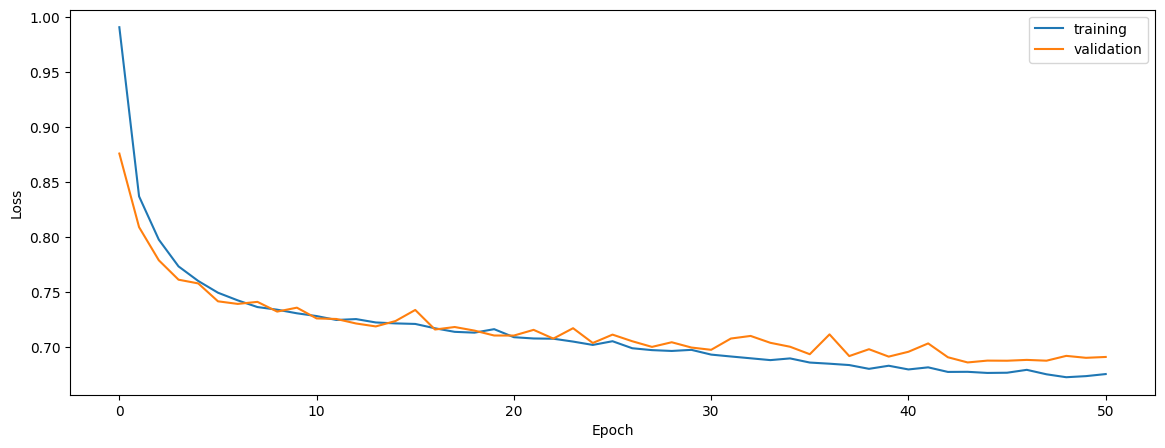

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7075483232740893


0.6981023999831838


0.6986366184060154


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.695016957224606


0.6856299329165645


0.7037521411045785


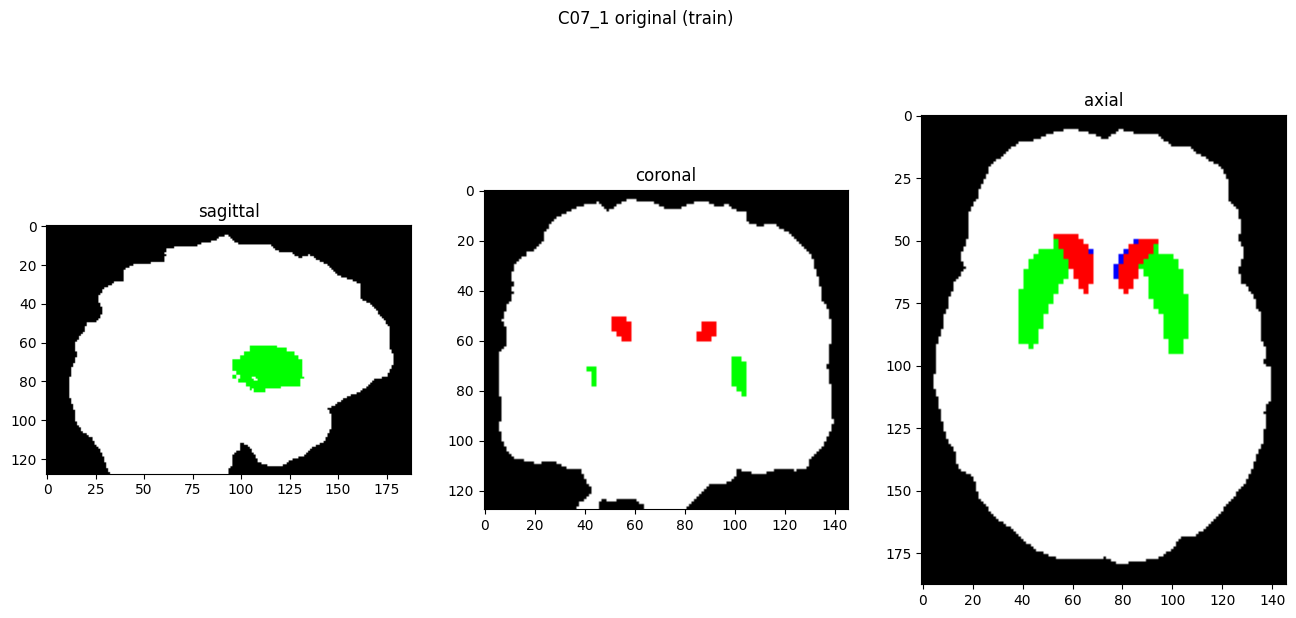

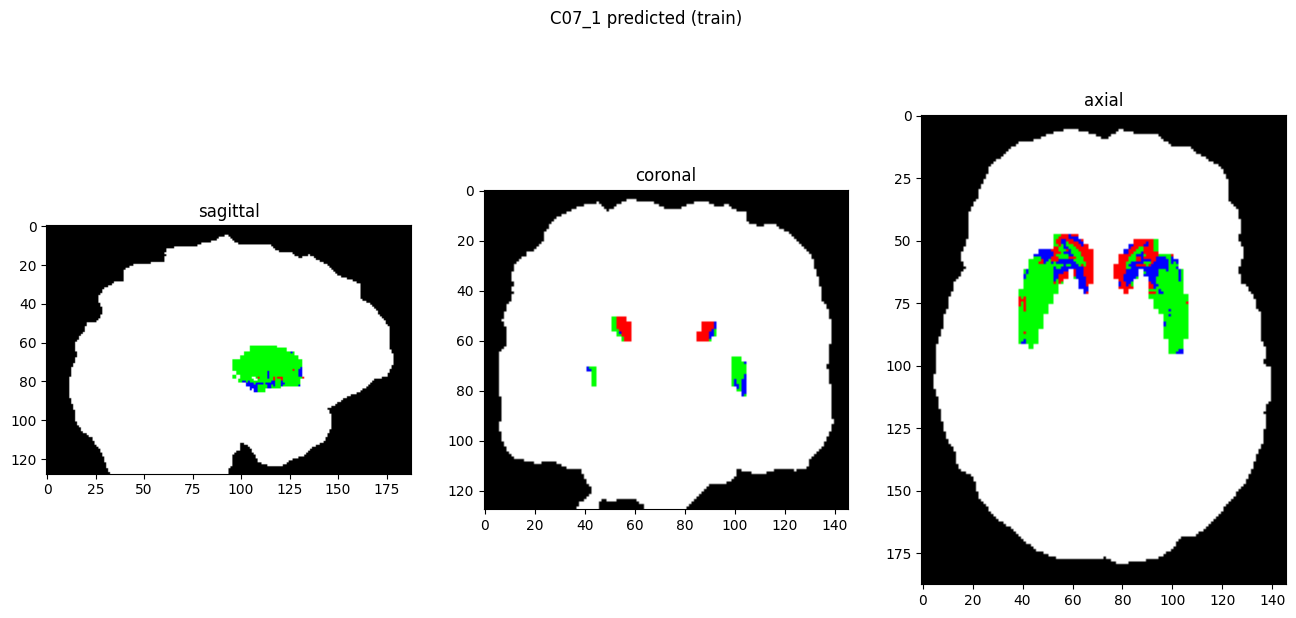

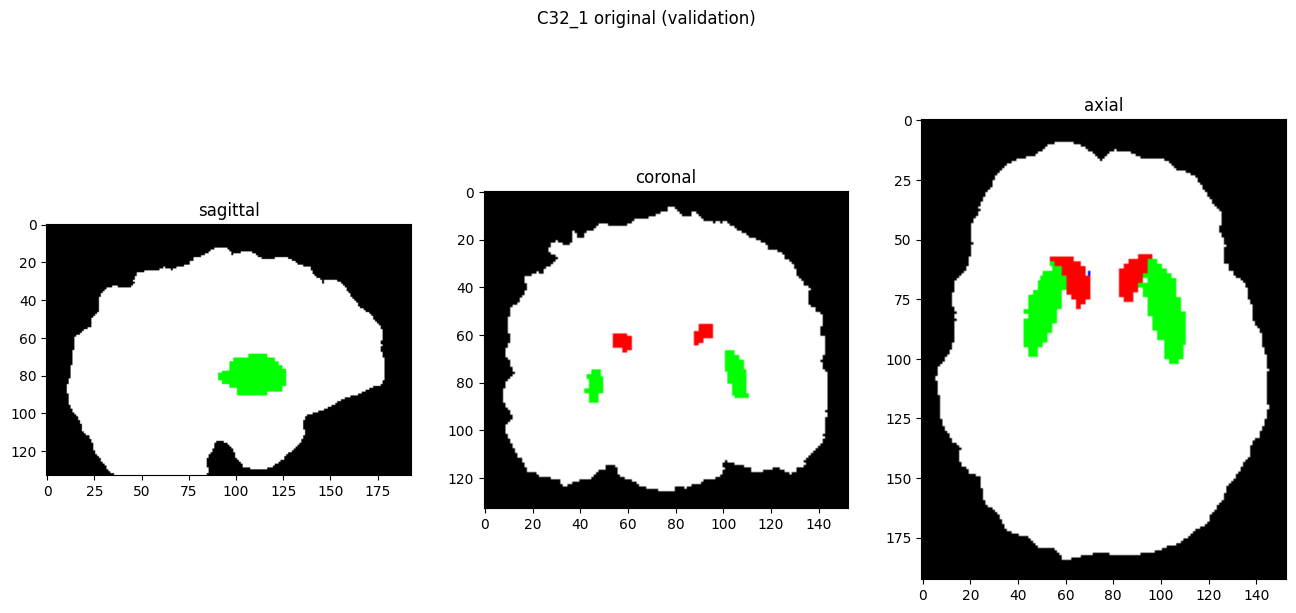

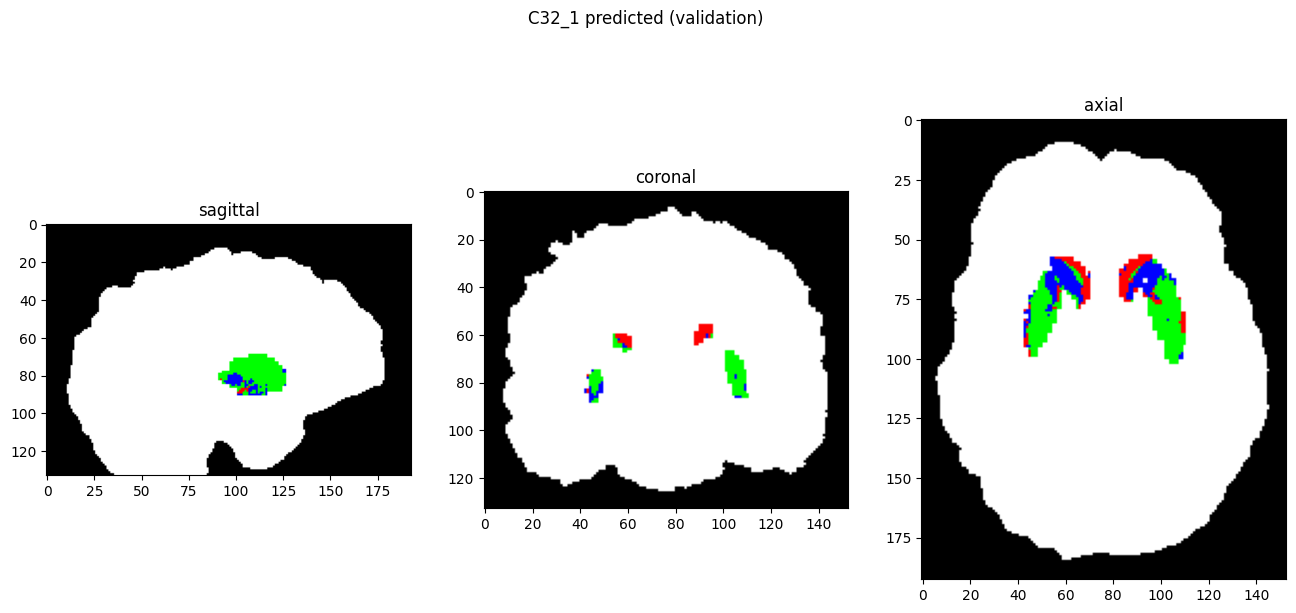

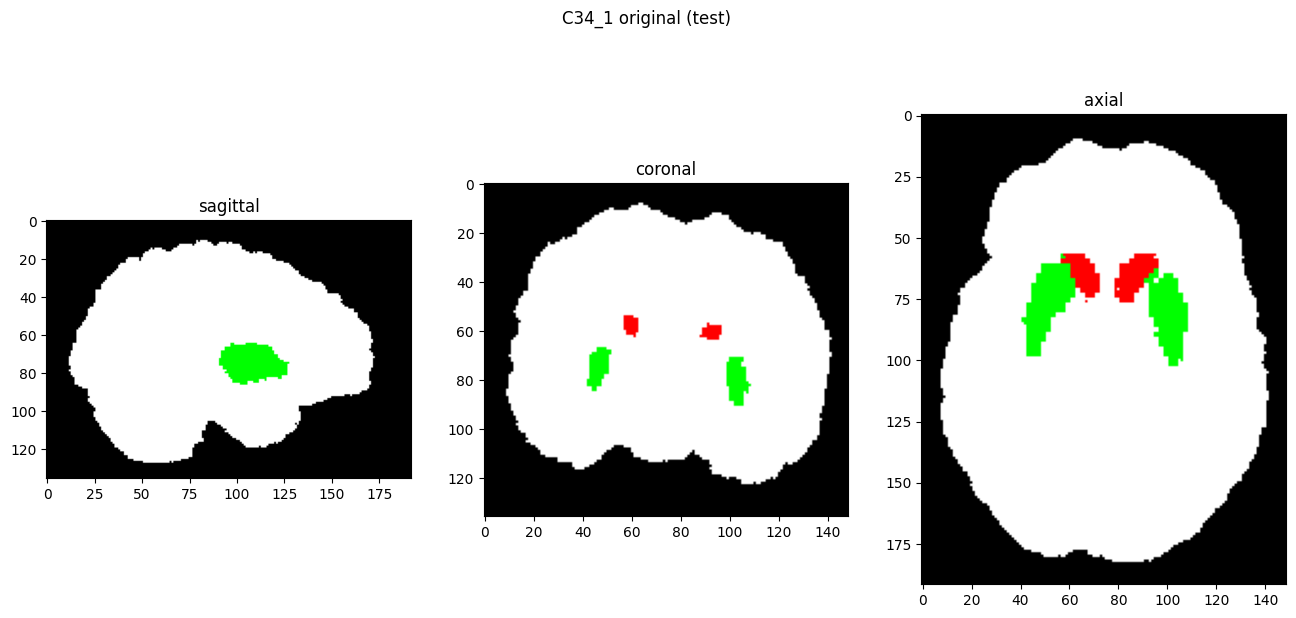

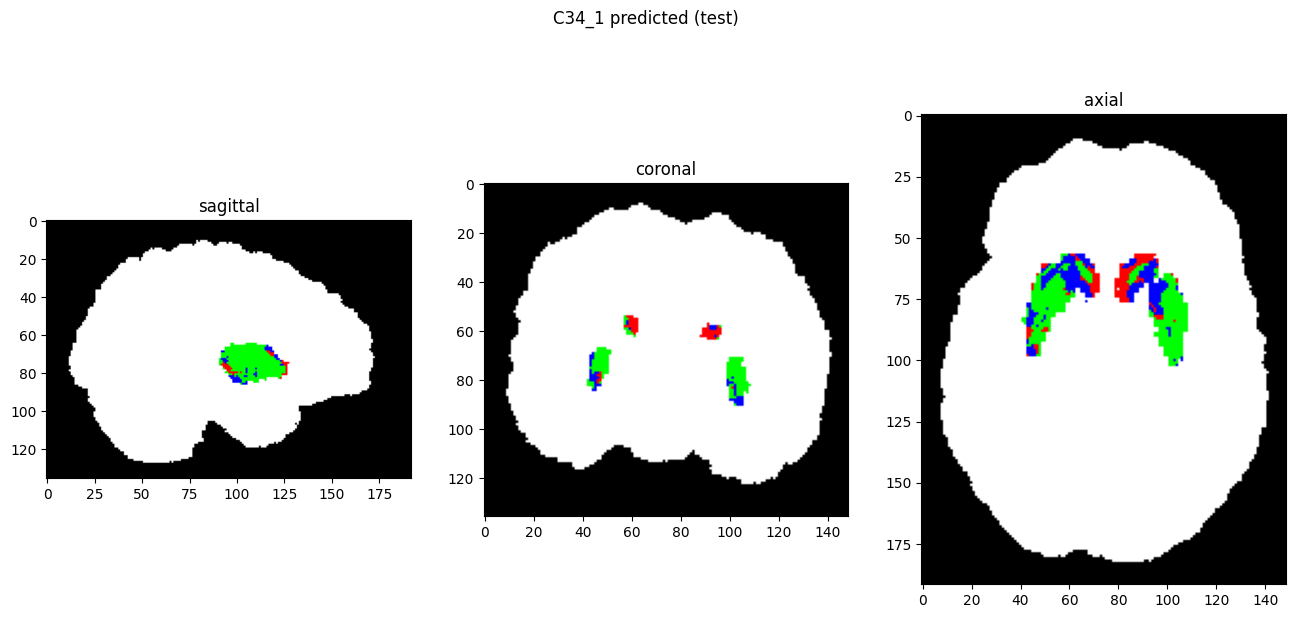

In [9]:
showResults(model, gen, threshold=0)